#***Введение: Cоздание набора данных Суммаризаций медицинских статей и Интерактивной карты***

Проект посвящен обработке текстов медицинских статей — это направление выбрано неслучайно. Биология и медицина всегда вызывали у меня большой интерес, и данная работа направлена на создание инструмента, который упростит поиск и анализ научных статей. Она стала отличной возможностью объединить интерес к этим областям с развитием навыков в обработке естественного языка и попробовать реализовать идею с нуля.  

### Основные цели проекта:  
1. **Экспериментальная площадка**: проект стал своего рода обучающей «песочницей» для изучения и тестирования подходов к обработке медицинских текстов, что позволило решить ряд практических задач и углубить понимание инструментов NLP.  
2. **Функциональность для работы с данными**:  
   - Создание набора данных для **суммаризации медицинских статей**, чтобы выделить ключевую информацию из текстов.  
   - Разработка **интерактивной карты**, которая визуализирует взаимосвязи между статьями на основе их содержания, облегчая их анализ и поиск тематических групп.  

### Ключевые особенности:  
- **Обучающий характер**: проект ориентирован на личное обучение и эксперименты, а результаты предназначены только для образовательных целей. Он **не подходит** для использования в профессиональной медицинской практике или научных исследованиях.  
- **Ограниченные ресурсы**:  
   - Проект выполнен с **минимальным бюджетом**, без применения сложных технологий.  
   - В выборке около **140 000 статей**, каждая из которых сокращена до **512 токенов**. Это накладывает ограничения на качество данных, делая возможными **ошибки** и **недостоверные выводы**.  

### Технические аспекты:  
Для минимизации ложных результатов итоговые суммаризации очищаются от чисел, формул и других технических элементов. Это помогает сосредоточиться на содержательной части текстов, при анализе тематической близости.  

Проект стал хорошим примером того, как даже на ограниченных ресурсах можно реализовать идеи, направленные на упрощение работы с научными данными.

#***0. Импорт необходимых библиотек и настройка окружения***

### ***0.1 Импорт библиотек***

In [ ]:
# Установка пакетов
!pip install langdetect textstat nltk tqdm-joblib sumy evaluate rouge_score bert-score dash

# Библиотеки для параллельного выполнения задач и отображения прогресса
from joblib import Parallel, delayed
from tqdm_joblib import tqdm_joblib
from tqdm.auto import tqdm
tqdm.pandas()

# Библиотеки для предобработки
import pandas as pd
import numpy as np
import pickle
import re
from collections import Counter, defaultdict
from bs4 import BeautifulSoup
from statistics import mean

# Библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# Библиотеки для обработки текста
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize, sent_tokenize
import gensim
import textstat
from langdetect import detect, DetectorFactory

# Библиотеки для обработки и использования моделей
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.lex_rank import LexRankSummarizer
from sumy.summarizers.text_rank import TextRankSummarizer
from sumy.summarizers.lsa import LsaSummarizer

from transformers import AutoTokenizer, AutoModel
import torch

# Метрики
import evaluate
from evaluate import load
from bert_score import score as bertscore

# Загрузка метрик
rouge = evaluate.load('rouge')
meteor = evaluate.load('meteor')
bertscore = load("bertscore")

# Библиотеки для анализа данных и машинного обучения
from sklearn.neighbors import KDTree
from sklearn.manifold import TSNE

# Dash
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output, State

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 11.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.1/105.1 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.3/97.3 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 980.2 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.10/dist-packages/tqdm_joblib/__init__.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


<ipython-input-1-a76b1f3310b3>:59: UserWarning: 
The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`
  import dash_core_components as dcc
<ipython-input-1-a76b1f3310b3>:60: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html


### ***0.2 Подключение к Google Drive и определение путей к данным***

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Определение путей к данным
raw_population_data = '/content/drive/MyDrive/Colab Notebooks/pmc_articles/raw_population_data/csv_files'  # Путь к папке с необработанными данными
raw = '/content/drive/MyDrive/Colab Notebooks/pmc_articles/pmc_articles_raw.csv'  # Путь к исходным данным
cleaned = '/content/drive/MyDrive/Colab Notebooks/pmc_articles/cleaned.csv'  # Путь к очищенным данным
summarized = '/content/drive/MyDrive/Colab Notebooks/pmc_articles/summarized.csv'  # Путь к суммированным данным
embeddings = '/content/drive/MyDrive/Colab Notebooks/pmc_articles/embeddings.csv'  # Путь к данным с векторными представлениями
complete = '/content/drive/MyDrive/Colab Notebooks/pmc_articles/complete.csv'  # Путь к полному набору данных

Mounted at /content/drive


# ***1. Анализ, оценка и обработка всех доступных данных***

**Этапы получения, распаковки, парсинга и преобразования исходных наборов данных** описаны в другом файле, а именно в **"parcing_from_pmc(Open_Access).ipynb"**, который находится в корневой директории проекта.

В текущей версии блокнота мы сосредоточимся только на работе с уже подготовленными данными, полученными в результате выполнения указанных этапов.

### ***1.1 Загрузка и объединение всех данных***

Этап сбора всех `.csv` файлов из папки `raw_population_data` заключается в объединении их в одну таблицу. После этого индексы сбрасываются, чтобы они начинались с нуля и не дублировались.

In [ ]:
file_paths = [os.path.join(raw_population_data, file) for file in os.listdir(raw_population_data) if file.endswith('.csv')]

df = pd.concat([pd.read_csv(file) for file in file_paths], ignore_index=True)
df.reset_index(drop=True, inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165851 entries, 0 to 165850
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   Title     165851 non-null  object
 1   Authors   165851 non-null  object
 2   PMC Link  165851 non-null  object
 3   Text      165848 non-null  object
dtypes: object(4)
memory usage: 5.1+ MB


### ***1.2 Фильтрация неанглийских текстов***

Устанавливаем фиксированное значение для `DetectorFactory.seed`, чтобы результаты определения языка были одинаковыми при каждом запуске.

Функция `is_english` проверяет, на каком языке написан текст. Если возникает ошибка (например, если текст слишком короткий для анализа), функция возвращает `False`.

Функция `filter_non_english` обрабатывает все строки в столбце `text_column`, проверяя, на каком языке они написаны. Процесс выполняется параллельно для ускорения работы. В конце выводится количество строк, написанных на английском и неанглийском языках, а затем возвращаются только строки на английском языке.

In [ ]:
DetectorFactory.seed = 0

def is_english(text):
    try:
        return detect(text) == 'en'
    except:
        return False

def filter_non_english(df, text_column):
    num_cores = -1
    results = Parallel(n_jobs=num_cores)(
        delayed(is_english)(text) for text in tqdm(df[text_column], desc="Проверка языка", total=len(df))
    )
    non_english_count = sum(not result for result in results)
    english_count = len(results) - non_english_count

    print(f"Количество записей, написанных на английском: {english_count}")
    print(f"Количество записей, не написанных на английском: {non_english_count}")

    return df[pd.Series(results)].reset_index(drop=True)

filtered_df = filter_non_english(df, 'Text')

Проверка языка:   0%|          | 0/165851 [00:00<?, ?it/s]

Количество записей, написанных на английском: 165052
Количество записей, не написанных на английском: 799


Количество текстов, не написанных на английском, составило **799**. Эти тексты были удалены из набора данных, оставив только те, что на английском языке.

### ***1.3 Токенизация и визуализация распределения токенов***

Подсчитываем количество токенов в каждом тексте с помощью функции **`count_tokens_nltk`**. Результаты подсчёта сохраняются в новый столбец **`token_count`**. Для ускорения процесса используется **параллельная обработка**, и значения для каждого текста из **`filtered_df['Text']`** записываются в этот столбец.

In [ ]:
def count_tokens_nltk(text):
    tokens = word_tokenize(text)
    return len(tokens)

results = Parallel(n_jobs=-1)(
    delayed(count_tokens_nltk)(text) for text in tqdm(filtered_df['Text'], desc="Подсчет токенов", total=len(filtered_df))
)
filtered_df['token_count'] = results

Подсчет токенов:   0%|          | 0/165052 [00:00<?, ?it/s]

Строим гистограмму распределения количества токенов с **50** интервалами и добавляем линию плотности. График показывает частоту появления текстов с разным количеством токенов. Также выводим статистическое описание столбца **`token_count`**, чтобы оценить основные характеристики распределения, такие как **среднее**, **стандартное отклонение**, **минимальное** и **максимальное** значения.

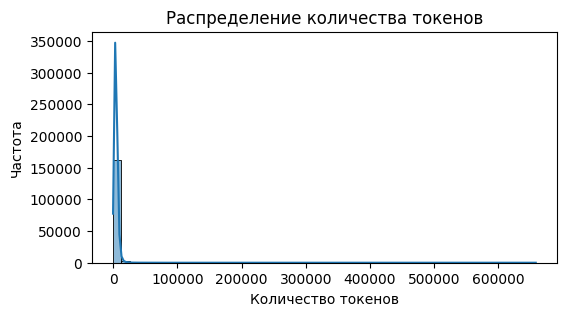

count    165052.000000
mean       4990.486386
std        4219.021112
min           2.000000
25%        3154.000000
50%        4536.000000
75%        6227.000000
max      658055.000000
Name: token_count, dtype: float64


In [ ]:
plt.figure(figsize=(6, 3))
sns.histplot(filtered_df['token_count'], bins=50, kde=True)
plt.title('Распределение количества токенов')
plt.xlabel('Количество токенов')
plt.ylabel('Частота')
plt.show()

print(filtered_df['token_count'].describe())

* Среднее количество токенов — **4990**.
* Стандартное отклонение — **4219**, что указывает на значительные различия в длине.
* Минимальное значение — **2 токена**, что может означать ошибочные или слишком короткие тексты.
* Максимум — **658,055 токенов**, что явно является аномально длинным текстом.
* 75% текстов содержат менее **6227 токенов**, что означает, что большая часть данных укладывается в более умеренную длину.

В данных есть как короткие строки, так и очень длинные тексты. Требуется дополнительная фильтрация или корректировка этих аномальных значений.

### ***1.4 Фильтрация текстов по количеству токенов***

Вычисляем и фильтруем тексты по количеству токенов, чтобы исключить аномалии и привести распределение к более нормальному виду. Это также помогает уменьшить выборку, удаляя **слишком короткие** и **слишком длинные** тексты, которые могут искажать анализ.

In [ ]:
print((filtered_df['token_count'] <= 512).sum())
print((filtered_df['token_count'] >= 10240).sum())

print(((filtered_df['token_count'] >= 512) & (filtered_df['token_count'] <= 10240)).sum())

6291
7327
151439


Оставляем только те тексты, количество токенов в которых больше **512** и меньше **10240**. Эти значения выбраны, так как они кратны **64** и **512**, что важно для дальнейшей обработки. На следующих этапах целевая длина итоговых суммаризаций будет составлять **512** токенов, поэтому тексты в пределах этих значений идеально подходят для дальнейшей работы, исключая **слишком короткие** и **слишком длинные** записи, которые могут мешать корректному анализу и моделированию.

In [ ]:
filtered_df = filtered_df[(filtered_df['token_count'] >= 512) & (filtered_df['token_count'] <= 10240)]

print(f"Оставшиеся записи: {len(filtered_df)}")

Оставшиеся записи: 151439


Повторная визуализация распределения количества токенов после фильтрации позволяет увидеть, как изменилось распределение данных. Это важно для оценки эффективности фильтрации и того, как она повлияла на диапазон длин текстов, исключив аномалии и приведя распределение к более нормальному виду.

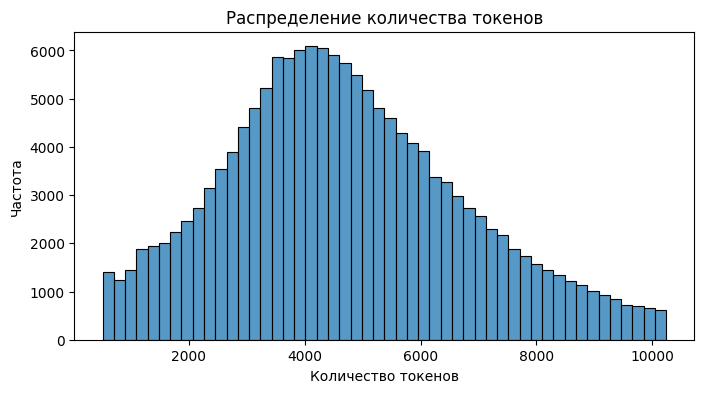

In [ ]:
plt.figure(figsize=(8, 4))
sns.histplot(filtered_df['token_count'], bins=50)
plt.title('Распределение количества токенов')
plt.xlabel('Количество токенов')
plt.ylabel('Частота')
plt.show()

Фильтрация аномалий с помощью простого удаления **8.9%** записей ожидаемо привела график к более нормальному распределению. Это подтверждает, что удаление слишком коротких и слишком длинных текстов помогло улучшить качество данных для дальнейшего анализа и обработки.

Удаляем столбец **`token_count`** из набора данных и сохраняем обновлённый набор данных (**`df_raw`**) в **CSV** файл.

In [ ]:
df_raw = filtered_df.drop(columns=['token_count'])

df_raw.to_csv(raw, index=False)

# ***2. Анализ и оценка созданной выборки***

### ***2.1 Загрузка и анализ данных***



In [ ]:
df_raw = pd.read_csv(raw)

Используем базовые методы для получения информации о наборе данных в целом.

In [ ]:
print("Общая информация о данных:")
df_raw.info()

print(f"\nКоличество дубликатов: {df_raw.duplicated().sum()}")

print("\nПропущенные значения в данных:")HkXt
print(df_raw.isnull().sum())

print("\nПервые 5 записей данных:")
df_raw.head()

Общая информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151439 entries, 0 to 151438
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   Title     151439 non-null  object
 1   Authors   151439 non-null  object
 2   PMC Link  151439 non-null  object
 3   Text      151439 non-null  object
dtypes: object(4)
memory usage: 4.6+ MB

Количество дубликатов: 0

Пропущенные значения в данных:
Title       0
Authors     0
PMC Link    0
Text        0
dtype: int64

Первые 5 записей данных:


,Title,Authors,PMC Link,Text
0,Androgen receptor profiling predicts prostate ...,"Suzan Stelloo, Ekaterina Nevedomskaya, Henk G ...",https://pmc.ncbi.nlm.nih.gov/articles/PMC4644377/,Prostate cancer is the second most common canc...
1,Arrested crossover precursor structures form s...,"Miao Tian, Kazufumi Mochizuki, Josef Loidl",https://pmc.ncbi.nlm.nih.gov/articles/PMC8849441/,Meiotic crossovers form the basis of genetic r...
2,Multiple interventions improve analgesic treat...,"Robert N Porter, Roger E Chafe, Leigh A Newhoo...",https://pmc.ncbi.nlm.nih.gov/articles/PMC4532201/,Provision of appropriate and timely treatment ...
3,The use of virtual reality and augmented reali...,"Katherine Kuyt, Sang-Hee Park, Todd P. Chang, ...",https://pmc.ncbi.nlm.nih.gov/articles/PMC8040758/,Virtual reality (VR) and augmented reality (AR...
4,MicroRNA-351 Regulates Two-Types of Cell Death...,"Akira Sato, Takuya Omi, Akihiro Yamamoto, Akit...",https://pmc.ncbi.nlm.nih.gov/articles/PMC4829180/,MicroRNAs (miRNAs) are endogenous small non-co...


In [ ]:
display(df_raw['Text'][9843])

'To investigate whether body mass index (BMI) trajectory, lifestyle and reproductive factors are associated with knee pain risk among middle-aged women.\n\nProspective study of the Japan Nurses’ Health Study (JNHS).\n\nThe JNHS investigates the health of female nurses in Japan. Biennial follow-up questionnaires are mailed to the participants.\n\nThe 7434 women aged over 40 years who responded to the 10-year self-administered follow-up questionnaire.\n\nSelf-reported knee pain at the 10-year follow-up was the primary outcome. We analysed BMI (normal or overweight) trajectory data from a baseline survey to the 10-year follow-up survey using group-based trajectory modelling. Exposure measurements were BMI trajectory, BMI at age 18 years, lifestyle variables and reproductive history.\n\nBMI trajectories from baseline to the 10-year follow-up were divided into four groups: remained normal, remained overweight, gained weight or lost weight. At the 10-year follow-up, 1281 women (17.2%) report

* На данном этапе наша выборка состоит из **151,439** записей.
* Дубликаты и пропущенные значения отсутствуют.
* Примеры текста содержат значительное количество шумов и лишних символов, которые будут обработаны позже, по ходу проекта.

### ***2.2 Статистический анализ текстов***

### ***2.2.1 Анализ Текстов***

Добавляем столбец с длиной текста **`text_length`**  и строим гистограмму распределения этой длины. Также выводим описательную статистику созданного столбца, чтобы оценить распределение длин текстов в символах, включая такие показатели как **среднее**, **стандартное отклонение**, **минимальное** и **максимальное** значения.

Статистические характеристки длины текстов:
count    151439.000000
mean      26706.061114
std       11708.610208
min        2367.000000
25%       18518.000000
50%       25584.000000
75%       34117.500000
max       89426.000000
Name: text_lenght, dtype: float64


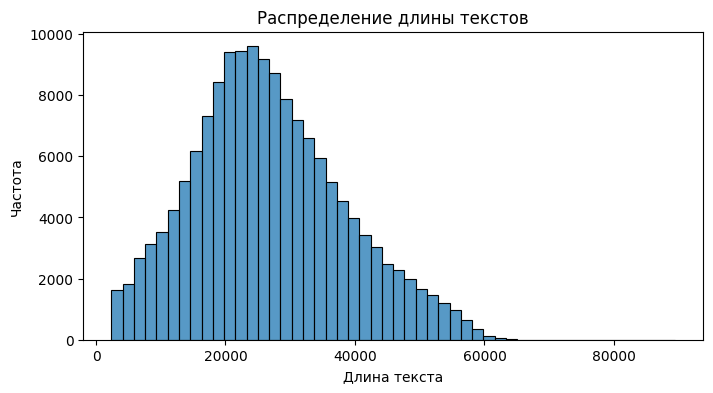

In [ ]:
df_raw['text_lenght'] = df_raw['Text'].apply(len)

plt.figure(figsize=(8,4))
sns.histplot(df_raw['text_lenght'], bins=50)
plt.title('Распределение длины текстов')
plt.xlabel('Длина текста')
plt.ylabel('Частота')
plt

print('Статистические характеристки длины текстов:')
print(df_raw['text_lenght'].describe())

* Средняя длина текста — **26,706** символов.
* Стандартное отклонение — **11,708**, что указывает на значительные различия в длине.
* Минимальное значение — **2,367** символов, что может означать ошибочные или слишком короткие тексты.
* Максимум — **89,426** символов, что явно является аномально длинным текстом.
* 75% текстов содержат менее **34,117** символов, что означает, что большая часть данных укладывается в более умеренную длину.

Тексты длиной более **60,000** символов являются выбросами и требуют дополнительной фильтрации или корректировки.

Функция **`sentence_and_word_count`** подсчитывает количество предложений в тексте и среднюю длину предложения (в словах). Для каждого текста в выборке вычисляются эти показатели, и результаты добавляются в новые столбцы **`sentence_count`** и **`avg_sentence_length`**.

In [ ]:
def sentence_and_word_count(text):
    sentences = nltk.sent_tokenize(text)
    sentence_lengths = [len(nltk.word_tokenize(sentence)) for sentence in sentences]
    avg_sentence_length = sum(sentence_lengths) / len(sentence_lengths) if sentence_lengths else 0
    return len(sentences), avg_sentence_length

results = Parallel(n_jobs=-1)(delayed(sentence_and_word_count)(text) for text in tqdm(df_raw['Text'], desc="Подсчет предложений и слов"))

df_raw[['sentence_count', 'avg_sentence_length']] = pd.DataFrame(results, index=df_raw.index)

Подсчет предложений и слов:   0%|          | 0/151439 [00:00<?, ?it/s]

Строим гистограмму распределения количества предложений и выводим описательную статистику для этого столбца. Это поможет оценить, как распределяются данные по количеству предложений в текстах, включая **среднее**, **стандартное отклонение**, **минимальные** и **максимальные** значения.

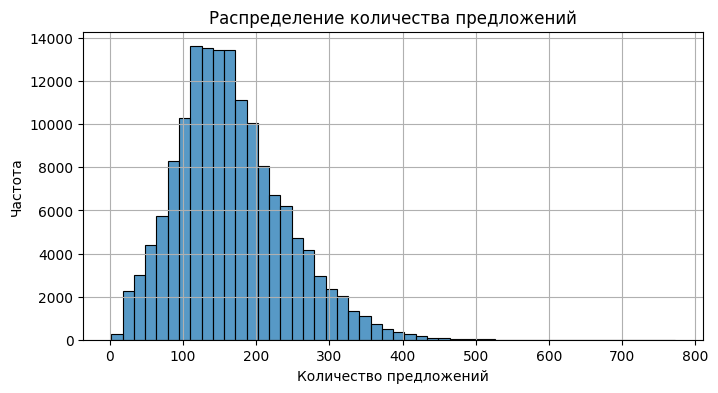

Статистические характеристики количества предложений:
count    151439.000000
mean        165.903446
std          74.938068
min           2.000000
25%         114.000000
50%         157.000000
75%         210.000000
max         772.000000
Name: sentence_count, dtype: float64


In [ ]:
plt.figure(figsize=(8, 4))
sns.histplot(df_raw['sentence_count'], bins=50)
plt.title('Распределение количества предложений')
plt.xlabel('Количество предложений')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

print("Статистические характеристики количества предложений:")
print(df_raw['sentence_count'].describe())

* Среднее количество предложений — **165.9**.
* Стандартное отклонение — **74.9**, что указывает на значительные различия в длине текстов.
* Минимальное количество предложений — **2**, что может свидетельствовать о очень коротких текстах.
* Максимум — **772 предложения**, что явно является аномально длинным текстом.
* 75% текстов содержат менее **210 предложений**, что означает, что большая часть данных укладывается в более умеренные размеры.

Тексты с количеством предложений более **400** являются выбросами и требуют дополнительной фильтрации или корректировки.

Строим гистограмму распределения средней длины предложений и выводим описательную статистику для этого столбца. Это даст представление о том, как распределяется средняя длина предложений в словах по всем текстам, включая **среднее**, **стандартное отклонение**, **минимальные** и **максимальные** значения.

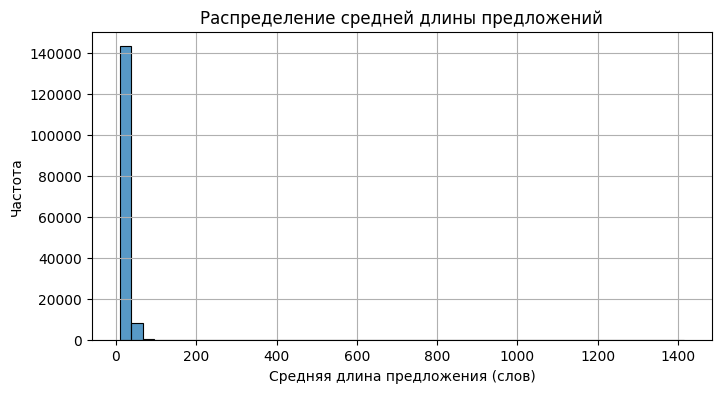

Статистические характеристики средней длины предложений:
count    151439.000000
mean         28.923789
std           8.154519
min          10.336420
25%          25.173512
50%          28.123967
75%          31.576037
max        1414.000000
Name: avg_sentence_length, dtype: float64


In [ ]:
plt.figure(figsize=(8,4))
sns.histplot(df_raw['avg_sentence_length'], bins=50)
plt.title('Распределение средней длины предложений')
plt.xlabel('Средняя длина предложения (слов)')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

print("Статистические характеристики средней длины предложений:")
print(df_raw['avg_sentence_length'].describe())

* Средняя длина предложения — **28.9** слов.
* Стандартное отклонение — **8.2**, что указывает на разнообразие в длине предложений.
* Минимальная длина предложения — **10.3** слова, что скорее всего соответствует кратким предложениям.
* Максимум — **1414 слов**, что явно является выбросом и аномально длинным предложением.
* 75% предложений имеют длину менее **31.6** слов, что означает, что большинство предложений укладываются в более умеренные размеры.

Тексты с предложениями длиной более **35** слов являются выбросами и требуют дополнительной фильтрации или корректировки.

### ***2.2.2 Анализ уникальных слов***

Создаем новый столбец `UniqueWordPercentage`, который вычисляет процент уникальных слов в каждом тексте. Этот показатель помогает понять разнообразие лексики: чем выше процент уникальных слов, тем более разнообразным является словарный запас текста.

In [ ]:
def compute_unique_word_percentage(text):
    words = nltk.word_tokenize(text)
    num_words = len(words)
    unique_words = len(set(words))
    return (unique_words / num_words) * 100 if num_words > 0 else 0

unique_word_percentages = Parallel(n_jobs=-1)(delayed(compute_unique_word_percentage)(text) for text in tqdm(df_raw['Text'], desc="Расчет процента уникальных слов"))

df_raw['UniqueWordPercentage'] = unique_word_percentages

Расчет процента уникальных слов:   0%|          | 0/151439 [00:00<?, ?it/s]

Строим гистограмму распределения процента уникальных слов и выводим описательную статистику для этого показателя.

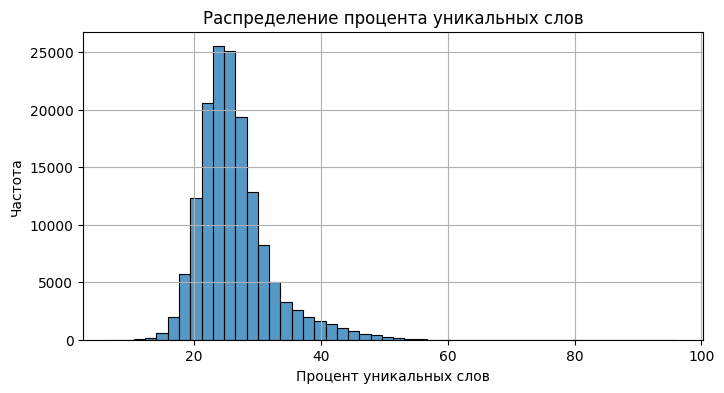

Статистические характеристики процента уникальных слов:
count    151439.000000
mean         26.284190
std           5.598128
min           6.967780
25%          22.699801
50%          25.337976
75%          28.539428
max          95.824635
Name: UniqueWordPercentage, dtype: float64


In [ ]:
plt.figure(figsize=(8,4))
sns.histplot(df_raw['UniqueWordPercentage'], bins=50)
plt.title('Распределение процента уникальных слов')
plt.xlabel('Процент уникальных слов')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

# Статистические характеристики процента уникальных слов
print("Статистические характеристики процента уникальных слов:")
print(df_raw['UniqueWordPercentage'].describe())

- **Средний процент уникальных слов** составляет **26.3%**.
- **Стандартное отклонение** — **5.6%**, что указывает на заметные различия в процентах уникальных слов между текстами.
- **Минимум** — **7% уникальных слов**, что может указывать на тексты с низким лексическим разнообразием.
- **Максимум** — **95.8% уникальных слов**, что является аномально высоким значением, возможно, для очень специфичных или коротких текстов.
- **75% текстов** содержат менее **28.5% уникальных слов**, что означает, что большая часть текстов имеет умеренное количество уникальных слов.

Необходимо провести дополнительную фильтрацию для устранения аномальных значений в тексте с очень низким или высоким процентом уникальных слов.

### ***2.2.3 Анализ метрик сложности текста***

Для оценки сложности текстов мы будем использовать несколько популярных метрик:

1. **Flesch-Kincaid**: Оценка сложности текста на основе средней длины предложений и средней длины слов.
2. **Gunning Fog**: Оценка сложности, учитывающая не только длину предложений, но и процент сложных слов (слова с тремя или более слогами).
3. **SMOG**: Оценка сложности текста на основе количества предложений с более чем 3 слогами.
4. **ARI** (Automated Readability Index): Оценка, основанная на средней длине слова и предложений.
5. **Coleman-Liau**: Метрика, вычисляющая сложность текста на основе среднего числа букв в словах и средней длины предложения.

Метрики помогают оценить, насколько сложен текст для восприятия. Чем выше значения, тем сложнее воспринимается текст. Для дальнейшего анализа значения этих метрик будут добавлены в новые столбцы в набор данных.

In [ ]:
def compute_readability_metrics(text):
    try:
        return {
            'Flesch-Kincaid': textstat.flesch_reading_ease(text),
            'Gunning Fog': textstat.gunning_fog(text),
            'SMOG': textstat.smog_index(text),
            'ARI': textstat.automated_readability_index(text),
            'Coleman-Liau': textstat.coleman_liau_index(text)
        }
    except:
        return {
            'Flesch-Kincaid': np.nan,
            'Gunning Fog': np.nan,
            'SMOG': np.nan,
            'ARI': np.nan,
            'Coleman-Liau': np.nan
        }

metrics = Parallel(n_jobs=-1)(delayed(compute_readability_metrics)(text) for text in tqdm(df_raw['Text'], desc="Расчет метрик сложности текста"))

metrics_df = pd.DataFrame(metrics)

df_raw = pd.concat([df_raw, metrics_df], axis=1)

Расчет метрик сложности текста:   0%|          | 0/151439 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Для визуализации распределения метрик сложности текста, таких как **Flesch-Kincaid**, **Gunning Fog**, **SMOG**, **ARI**, и **Coleman-Liau**, строим **boxplot** для каждой из этих метрик. Boxplot позволит нам понять медиану, разброс значений и выявить возможные выбросы для каждой метрики.

Также вычислим средние значения и стандартные отклонения для каждой из метрик, чтобы понять общие тенденции и варьирование сложности в текстах.

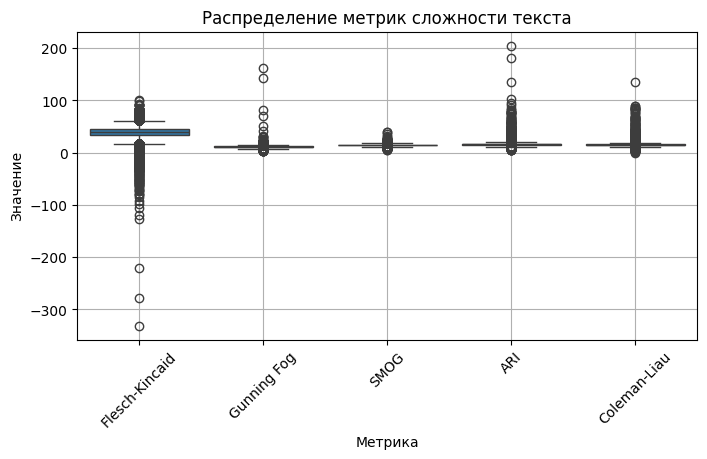

Средние значения метрик сложности текста:
Flesch-Kincaid    38.733681
Gunning Fog       11.299441
SMOG              14.567460
ARI               15.723497
Coleman-Liau      14.996138
dtype: float64

Стандартные отклонения метрик сложности текста:
Flesch-Kincaid    9.210787
Gunning Fog       1.696361
SMOG              1.375260
ARI               2.532795
Coleman-Liau      2.073631
dtype: float64


In [ ]:
plt.figure(figsize=(8,4))
sns.boxplot(data=df_raw[['Flesch-Kincaid', 'Gunning Fog', 'SMOG', 'ARI', 'Coleman-Liau']])
plt.title('Распределение метрик сложности текста')
plt.xlabel('Метрика')
plt.ylabel('Значение')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

print("Средние значения метрик сложности текста:")
print(df_raw[['Flesch-Kincaid', 'Gunning Fog', 'SMOG', 'ARI', 'Coleman-Liau']].mean())

print("\nСтандартные отклонения метрик сложности текста:")
print(df_raw[['Flesch-Kincaid', 'Gunning Fog', 'SMOG', 'ARI', 'Coleman-Liau']].std())

Средние значения метрик сложности текста указывают на то, что большая часть текстов в выборке имеет среднюю сложность, с некоторыми вариациями, что можно ожидать в большом наборе данных с разнообразными текстами. Стандартные отклонения метрик подтверждают наличие как более лёгких, так и более сложных текстов, что позволяет учитывать это при дальнейшей обработке данных.

### Основные выводы:
- **Flesch-Kincaid**: Среднее значение **38.7** указывает на тексты средней сложности, которые обычно считаются доступными для широкого круга читателей.
- **Gunning Fog**: Среднее значение **11.3** также указывает на тексты средней сложности, что соответствует повседневной литературе.
- **SMOG**: Среднее значение **14.6** предполагает, что тексты подходят для широкого круга читателей, но с некоторыми трудностями.
- **ARI**: Среднее значение **15.7** говорит о среднесложных текстах.
- **Coleman-Liau**: Среднее значение **15.0** также свидетельствует о текстах средней сложности.

### Стандартные отклонения:
- **Flesch-Kincaid** имеет стандартное отклонение **9.21**, что указывает на большое разнообразие сложности текстов, с возможными как простыми, так и сложными примерами.
- **Gunning Fog** и **SMOG** имеют меньшие стандартные отклонения, что говорит о большей однородности сложности текстов по этим метрикам.

Таким образом, хотя тексты в целом имеют умеренную сложность, присутствуют и выбросы с очень простыми или очень сложными текстами, что требует дальнейшей фильтрации или корректировки.

Строим тепловую карту корреляции метрик сложности текста.

* Положительные значения (красный цвет) указывают на высокую корреляцию между метриками, то есть если одна метрика возрастает, то другие тоже склонны увеличиваться.
* Отрицательные значения (синий цвет) означают, что метрики изменяются в противоположных направлениях.
* Значения, близкие к **0**, указывают на отсутствие значимой корреляции между метриками.


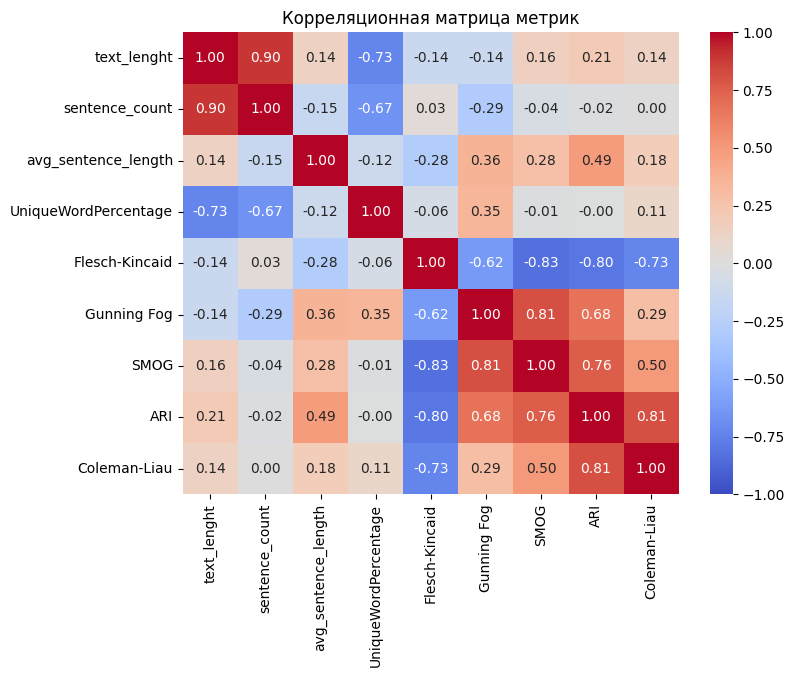

In [ ]:
numeric_columns = df_raw.select_dtypes(include=['number']).columns
correlation = df_raw[numeric_columns].corr()

plt.figure(figsize=(8,6))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title('Корреляционная матрица метрик')
plt.show()

Корреляционная матрица метрик сложности текста предоставляет полезную информацию о том, как различные характеристики текста связаны между собой. Рассмотрим ключевые выводы:

1. **Длина текста и количество предложений (0.90)**:
   - Это высокая положительная корреляция, что вполне ожидаемо. Длинные тексты, как правило, состоят из большего количества предложений.

2. **Длина текста и процент уникальных слов (-0.73)**:
   - Негативная корреляция говорит о том, что в длинных текстах часто встречаются повторяющиеся слова, что снижает их уникальность. Более короткие тексты склонны иметь более разнообразный лексикон.

3. **Длина предложений и метрики сложности**:
   - Умеренная положительная корреляция между длиной предложения и метриками сложности (Gunning Fog, SMOG, ARI). Это подтверждает гипотезу о том, что более сложные тексты содержат более длинные предложения.

4. **Метрики сложности текста**:
   - Все метрики сложности текста (Flesch-Kincaid, Gunning Fog, SMOG, ARI, Coleman-Liau) сильно коррелируют друг с другом. Это указывает на то, что эти метрики оценивают схожие аспекты сложности, такие как длина предложений и использование сложных слов.

5. **Процент уникальных слов**:
   - Негативная корреляция с длиной текста и количеством предложений подтверждает, что более длинные тексты часто содержат меньше уникальных слов, что также может быть связано с использованием повторяющихся фраз и терминов.

Эти выводы помогают понять, как текстовые характеристики могут быть взаимосвязаны, что полезно для дальнейшего анализа и очистки данных перед более глубокой обработкой.

Анализ данных выявил несколько аномалий и проблемы с распределением метрик, что может влиять на дальнейшие этапы работы. В следующем разделе мы сосредоточимся на очистке и преобразовании данных, минимизируя потерю записей, чтобы улучшить качество модели и снизить влияние выбросов и других аномалий.

# ***3. Предобработка данных***

### ***3.1 Предварительная очистка текстов***


In [ ]:
df_preprocessing = pd.read_csv(raw)

Определяем **глобальный паттерн регулярных выражений** и сохраняем его в переменной `patterns`. Как уже говорилось ранее, наши тексты будут очищены от всего, что не является **текстом** или **аббревиатурами**, включая все типы **чисел**. Это необходимо для минимизации ложноположительных результатов при расчете взаимосвязей на основе **эмбеддингов**, которые мы получим далее.

На основе многократного **ручного тестирования** результатов до и после очистки было выявлено, что данный паттерн работает достаточно хорошо для наших целей.

In [ ]:
patterns = {
    r'http[s]?://\S+': "URL",
    r'\[\d+(,\d+)*\]': "Ссылки в квадратных скобках (числовые)",
    r'\[.*?\]': "Ссылки в квадратных скобках",
    r'et al\.': "'et al.'",
    r'e\.g\.': "'e.g.'",
    r'\bf\b': "'f' как отдельная буква",
    r'\bmm\b': "'mm' как отдельные буквы",
    r'al\b': "'al' как отдельные буквы",
    r'[\*\&]': "Лишние символы (*&)",
    r'\S{35,}': "Длинные слова (более 35 символов)",
    r'\b\d+\b': "Числа",
    r'\b\d+(\.\d+)?%\b': "Проценты",
    r'\b\d+(\.\d+)?\s*[a-zA-Z]*\b': "Формулы",
    r'[\d/]+': "Дроби или числа",
    r'[^\w\s,.?!;:—\-]': "Лишние знаки препинания",
    r'\bFigure\w*\b': "Упоминания Figure",
    r'\bFig[.\s]?[A-Za-z]?\b': "Упоминания Fig, Fig. A, Fig A, и т.д.",
    r'(?<=\s)(\d+(\.\d+)?)\s*(%|\b)': "Числовые значения без процента",
    r'[;:]': "Символы ':' и ';'",
    r'(?<!\w)-|-(?!\w)': "Дефисы, не в составных словах",
    r'\b[ivxlc]+\b': "Римские цифры",
    r'\s+': "Лишние пробелы",
    r',\s*(?=\.)': "Запятая перед точкой",
    r'([.,]{2,})+': "Повторяющиеся знаки препинания",
    r'([.,]\s*){2,}': "Повторяющиеся знаки препинания с пробелами",
    r'\b(?!a|an|the)\b[A-Za-z]\b': "Одиночные буквы (кроме a)",
    r'\b(\w+)(\s*,?\s*\1)+\b': "Повторяющиеся подряд слова",
    r'\b\d+\.\d+[^\w\s]\d*\b': "Удаление чисел с точками (например, 10.1038/s41467-018-06565-8)",
    r',\s*\.': "Запятая и точка с пробелами",
    r'\s?\.(?=\s*[a-z])': "Точка перед маленькой буквой",
    r'\band\s*\.\s*': "'and .' с пробелами вокруг",
    r'([.,])\s*\1+': "Повторяющиеся знаки препинания",
    r'\b[A-Z]{7,}\b': "Белки или геномы (последовательности из 7 и более заглавных букв)",
    r'[α-ωΑ-Ω]': "Греческие буквы и специальные символы"
}

Функция `clean_text` очищает текст от **HTML-тегов**, **нежелательных символов** и **чисел**, заменяя их пробелами, используя заранее заданные **регулярные выражения**. Затем удаляет лишние пробелы и пробелы перед знаками препинания, оставляя только **текст** и **аббревиатуры**.

In [ ]:
def clean_text(text):
    text = BeautifulSoup(text, "html.parser").get_text()

    for pattern, description in patterns.items():
        matches = re.findall(pattern, text)
        if matches:
            print(f"\n{description}: {matches}")
            text = re.sub(pattern, ' ', text)

    text = re.sub(r'\s+', ' ', text).strip()
    text = re.sub(r'\s+([.,])', r'\1', text)

    return text

Запрашиваем **индекс текста**, выбираем строку из **набора данных**, очищаем текст с помощью функции `clean_text` и выводим **оригинальный** и **очищенный текст** для сравнения.

In [ ]:
num = int(input())

test_text = df_preprocessing['Text'][num]
cleaned_text = clean_text(test_text)

print("\n" + "-" * 50 + "\n")
display(df_preprocessing['Text'][num])
print("\n" + "-" * 50 + "\n")
display(cleaned_text)

9405

Ссылки в квадратных скобках (числовые): [',2', '', '', ',4', ',9', '', '', '', ',11', '', '', ',15', '', ',18', '', '', '', '', ',9', '', '', '', ',14', '', '', '', '', '', '', '', '', '', '', '', '', '', ',14', ',4', ',8', ',10', ',24', '', ',14', '', '', '', '', '', '']

Ссылки в квадратных скобках: ['[(systolic BP − diastolic BP)/3]']

'et al.': ['et al.', 'et al.']

'e.g.': ['e.g.', 'e.g.']

'al' как отдельные буквы: ['al', 'al', 'al', 'al', 'al', 'al', 'al', 'al', 'al', 'al', 'al', 'al', 'al', 'al', 'al', 'al', 'al', 'al', 'al', 'al', 'al', 'al', 'al', 'al', 'al', 'al', 'al', 'al', 'al', 'al', 'al', 'al', 'al', 'al', 'al', 'al', 'al', 'al', 'al', 'al', 'al', 'al', 'al', 'al', 'al', 'al', 'al', 'al', 'al', 'al', 'al', 'al', 'al', 'al', 'al', 'al', 'al', 'al', 'al', 'al', 'al', 'al', 'al', 'al', 'al', 'al', 'al', 'al', 'al', 'al', 'al', 'al', 'al', 'al', 'al', 'al', 'al']

Лишние символы (*&): ['&', '&', '&']

Длинные слова (более 35 символов): ['δ-HCH,p,p’-dichlorodiphenyltri

'Metabolic syndrome (MetS) represents a cluster of metabolic abnormalities commonly defined by obesity, glycosemia, reduced high-density lipoprotein cholesterol (HDL-c) level, hypertriglyceridemia, and hypertension [1,2]. In addition, these are known precursors to cardiovascular disease. Mounting evidence from experimental and epidemiological studies suggests that exposure to endocrine disruptors such as persistent organic pollutants (POPs) may be linked to metabolic dysfunction, such as obesity [3], insulin resistance [3], dyslipidemia [3,4], hypertension [5,6,7,8,9], and MetS morbidity [10] or new-diagnosed MetS [11]. POPs (including PCBs and OCPs) are synthetic (artificially produced) organic chemicals used in pesticides or industrial products. POPs can accumulate in the food chain and tend to remain in fat-rich tissues. The impact of POP accumulation on the lifespan remains unclear, but it has been suggested that POPs function as endocrine disruptors. The increased concerns regardi


--------------------------------------------------



'Metabolic syndrome MetS represents a cluster of metabolic abnormalities commonly defined by obesity, glycosemia, reduced high-density lipoprotein cholesterol HDL- level, hypertriglyceridemia, and hypertension. In addition, these are known precursors to cardiovascular disease. Mounting evidence from experiment and epidemiologic studies suggests that exposure to endocrine disruptors such as persistent organic pollutants POPs may be linked to metabolic dysfunction, such as obesity, insulin resistance, dyslipidemia, hypertension, and MetS morbidity or new-diagnosed MetS. POPs including PCBs and OCPs are synthetic artificially produced organic chemicals used in pesticides or industri products. POPs can accumulate in the food chain and tend to remain in fat-rich tissues. The impact of POP accumulation on the lifespan remains unclear, but it has been suggested that POPs function as endocrine disruptors. The increased concerns regarding the health risks of endocrine disruptors, including POPs

Пересоздаем функцию `clean_text` и применяем ее ко всему **набору данных**, сохраняя полученные результаты в новый столбец.

In [ ]:
def clean_text(text):
    text = BeautifulSoup(text, "html.parser").get_text()

    for pattern in patterns.keys():
        text = re.sub(pattern, ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    text = re.sub(r'\s+([.,])', r'\1', text)

    return text

tqdm.pandas(desc="Cleaning Text")
results = Parallel(n_jobs=-1)(
    delayed(clean_text)(text) for text in tqdm(df_preprocessing['Text'], desc="Очистка текста")
)
df_preprocessing['Clean_Text'] = results

Очистка текста:   0%|          | 0/151439 [00:00<?, ?it/s]

In [ ]:
df_preprocessing['Clean_Text'][0]

'Prostate cancer is the second most common cancer in men, with worldwide more than one million new patients diagnosed and, deaths annually Torreet. When the disease is confined to the prostate, patients can be treated with prostatectomy and or radiotherapy with a curative intent. However, the disease recurs in of patients, for which there is no cure Amlinget. Androgen receptor AR plays a pivot role in prostate cancer development and progression, by mediating transcription of pro-mitotic genes, including UBE and cyclin, resulting in prostate cancer cell proliferation Xuet, Wanget. Upon androgen stimulation, AR dissociates from its chaperones and translocates to the nucleus Brinkmannet. Subsequently, AR binds at distinct genomic regions to mediate expression of directly responsive genes, ultimately leading to tumor cell proliferation Itkonen Mills. AR binding requires accessible chromatin, which is facilitated by pioneer factors, including FOXA and GATA Bohmet. Chromatin-bound AR subsequ

Вычисляем длину текстов до и после очистки, добавляем соответствующие столбцы. Рассчитываем процент сокращения текста и сохраняем результат в новый столбец **`Reduction_Percentage`**.

In [ ]:
df_preprocessing['Original_Length'] = df_preprocessing['Text'].apply(len)
df_preprocessing['Cleaned_Length'] = df_preprocessing['Clean_Text'].apply(len)

df_preprocessing['Reduction_Percentage'] = (
    (df_preprocessing['Original_Length'] - df_preprocessing['Cleaned_Length']) /
    df_preprocessing['Original_Length']
) * 100

Строим гистограмму для визуализации распределения **процента сокращения текста** и выводим описательную статистику для созданного столбца.

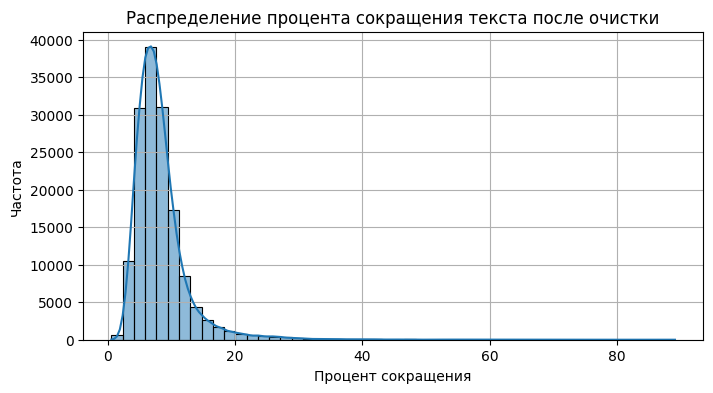

Статистические характеристики процента сокращения текста:
count    151439.000000
mean          8.272007
std           4.543692
min           0.565201
25%           5.681033
50%           7.401222
75%           9.524618
max          89.110694
Name: Reduction_Percentage, dtype: float64


In [ ]:
plt.figure(figsize=(8,4))
sns.histplot(df_preprocessing['Reduction_Percentage'], bins=50, kde=True)
plt.title('Распределение процента сокращения текста после очистки')
plt.xlabel('Процент сокращения')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

print("Статистические характеристики процента сокращения текста:")
print(df_preprocessing['Reduction_Percentage'].describe())

Статистические характеристики процента сокращения текста:

- **Средний процент сокращения** — **8.27%**, что указывает на умеренное сокращение текста в процессе очистки.
- **Стандартное отклонение** — **4.54%**, что говорит о разнообразии в уровне сокращения: некоторые тексты очищаются значительно больше, чем другие.
- **Минимальное значение** — **0.57%**, что может указывать на тексты с минимальными изменениями после очистки.
- **Максимум** — **89.11%**, что явно является выбросом, возможно, из-за значительных изменений в отдельных текстах.
- **75% текстов** имеют сокращение менее **9.52%**, что означает, что большинство текстов не теряет слишком много информации в процессе очистки.

Тексты с процентом сокращения более **20%** требуют дополнительной обработки.

Порог для аномальных сокращений установлен на уровне **20%**. Для идентификации аномальных записей, выбираем те, у которых процент сокращения превышает **20%** или имеет отрицательное значение. Далее подсчитываем количество таких записей.

Для этого мы выполняем следующие шаги:

1. Фильтруем данные, чтобы выбрать записи с **Reduction_Percentage > 20%** или с отрицательными значениями (**Reduction_Percentage < 0**).
2. Подсчитываем количество таких записей.

Результат покажет, сколько записей требуют дополнительной проверки и корректировки.

In [ ]:
threshold = 20

anomalies = df_preprocessing[df_preprocessing['Reduction_Percentage'] > threshold]
negatives = df_preprocessing[df_preprocessing['Reduction_Percentage'] < 0]

total_anomalies = anomalies.shape[0] + negatives.shape[0]
print(f"Количество записей с сокращением более {threshold}% и менее 0%: {total_anomalies}")

Количество записей с сокращением более 20% и менее 0%: 3594


In [ ]:
df_preprocessing = df_preprocessing[
    (df_preprocessing['Reduction_Percentage'] <= threshold) &
    (df_preprocessing['Reduction_Percentage'] >= 0)
].reset_index(drop=True)

print(f"Удалено записей: {total_anomalies}")
print(f"Оставшееся количество записей: {df_preprocessing.shape[0]}")

Удалено записей: 3594
Оставшееся количество записей: 147845


Строим гистограмму для визуализации распределения процента сокращения текста и выводим описательную статистику для созданного столбца.

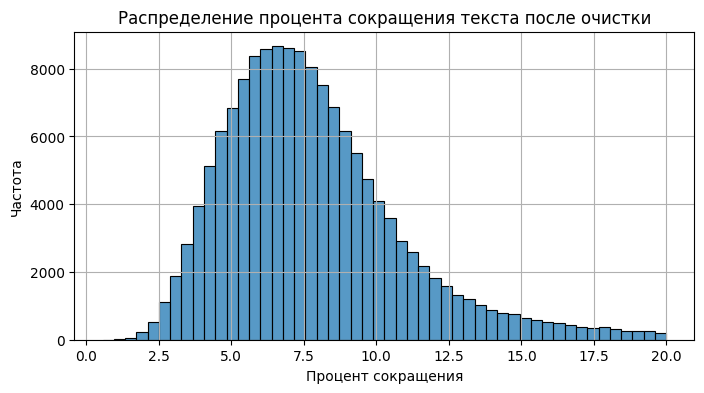

Статистические характеристики процента сокращения текста:
count    147845.000000
mean          7.795471
std           3.071884
min           0.565201
25%           5.640197
50%           7.321081
75%           9.323218
max          19.993587
Name: Reduction_Percentage, dtype: float64


In [ ]:
plt.figure(figsize=(8,4))
sns.histplot(df_preprocessing['Reduction_Percentage'], bins=50)
plt.title('Распределение процента сокращения текста после очистки')
plt.xlabel('Процент сокращения')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

print("Статистические характеристики процента сокращения текста:")
print(df_preprocessing['Reduction_Percentage'].describe())

- **Средний процент сокращения** — **7.80%**: большинство текстов теряет около 8% своего объема при очистке, что свидетельствует о умеренной степени очистки данных.
- **Стандартное отклонение** — **3.07%**: указывает на умеренные различия в уровне сокращения между текстами, показывая, что в выборке есть как тексты с небольшими, так и с более значительными изменениями.
- **Минимальное значение** — **0.57%**: это может означать, что для некоторых текстов процесс очистки практически не влияет на их длину.
- **Максимальное значение** — **19.99%**: это верхний предел сокращения, что указывает на значительные изменения в отдельных текстах.
- **25% текстов** имеют сокращение менее **5.64%**, а **75%** — менее **9.32%**, что означает, что большая часть текстов теряет не более 9% своего объема, а значительные сокращения встречаются реже.



Отбрасываем столбец с исходными текстами, так как он больше не будет использоваться в дальнейшей обработке.

In [ ]:
df_preprocessing.drop(columns=['Text'], inplace=True)

### ***3.2 Дополнительная очистка на основе токенизации***


После предварительной очистки текста, мы проведем дополнительную обработку с помощью функции `tokenize_and_analyze`, основанной на токенизации, чтобы выявить и устранить оставшиеся аномалии, такие как очень длинные слова или предложения.

In [ ]:
def tokenize_and_analyze(text):
    sentences = nltk.sent_tokenize(text)
    words = nltk.word_tokenize(text)
    word_lengths = [len(word) for word in words]
    return sentences, words, word_lengths

results = Parallel(n_jobs=-1)(
    delayed(tokenize_and_analyze)(text) for text in tqdm(df_preprocessing['Clean_Text'], desc="Токенизация и анализ слов", total=len(df_preprocessing['Clean_Text']))
)
df_preprocessing[['Sentences', 'Words', 'Word_Lengths']] = pd.DataFrame(results, index=df_preprocessing.index)

Токенизация и анализ слов:   0%|          | 0/147845 [00:00<?, ?it/s]

Собираем все длины слов в один список и вычисляем статистические характеристики для длины слов. Полученные данные выводим с округлением **до двух знаков после запятой**.

In [ ]:
all_word_lengths = [length for sublist in df_preprocessing['Word_Lengths'] for length in sublist]

word_lengths_series = pd.Series(all_word_lengths)
print("Статистические характеристики длины слов:")
print(word_lengths_series.describe().apply(lambda x: f"{x:,.2f}"))

Статистические характеристики длины слов:
count    598,690,260.00
mean               5.16
std                3.35
min                1.00
25%                3.00
50%                4.00
75%                7.00
max              209.00
dtype: object


**Статистические характеристики длины слов:**

- **Средняя длина слова** составляет **5.16**.
- **Стандартное отклонение** равно **3.35**, что указывает на разнообразие в длине слов.
- **Минимальная длина** слова — **1.00**, что, вероятно, связано с односимвольными словами.
- **Максимальная длина** слова достигает **209.00**, что является выбросом и может быть вызвано ошибками в токенизации или очень редкими длинными словами.
- **25%** всех слов имеют длину менее **3.00** символов, **50%** — менее **4.00** символов, а **75%** — менее **7.00** символов.

Длинные слова, длина которых превышает **35 символов**, считаются аномальными и требуют дополнительной обработки.

### ***3.2.1 Замена дефисов в длинных словах и повторная токенизация***


После анализа слов с аномальной длиной была разработана функция `replace_hyphens_in_long_words` и паттерн очистки с использованием регулярных выражений. В частности, если слово длиной более **30 символов** содержит дефисы, оно считается сложным медицинским термином, и дефисы заменяются пробелами. Это помогает избежать аномальных значений длины слов и приводит распределение длины к более нормальному виду.

In [ ]:
def replace_hyphens_in_long_words(text):

    def replace(match):
        word = match.group(0)
        return word.replace('-', ' ')

    return re.sub(r'\b[\w-]{31,}\b', replace, text)

df_preprocessing['Clean_Text'] = df_preprocessing['Clean_Text'].apply(replace_hyphens_in_long_words)

tokenized_results = Parallel(n_jobs=-1)(
    delayed(tokenize_and_analyze)(text) for text in tqdm(df_preprocessing['Clean_Text'], desc="Повторная токенизация", total=len(df_preprocessing['Clean_Text']))
)
df_preprocessing[['Sentences', 'Words', 'Word_Lengths']] = pd.DataFrame(tokenized_results, index=df_preprocessing.index)

Повторная токенизация:   0%|          | 0/147845 [00:00<?, ?it/s]

- **Замена дефисов на пробелы в длинных словах** позволяет правильно разделить сложные термины на составляющие, улучшая точность обработки текста.  
- **Повторная токенизация** необходима после изменения текста, чтобы обновить списки предложений и слов, что обеспечивает актуальность данных для дальнейшего анализа.

Функция **`remove_outliers_by_word_length`** используется для удаления записей, в которых встречаются слова длиной более заданного максимума (в данном случае — **35 символов**). Для этого она проверяет каждое слово в тексте и исключает те записи, где присутствуют аномально длинные слова, что помогает очистить данные от выбросов и улучшить качество последующего анализа.

In [ ]:
def remove_outliers_by_word_length(df, max_word_length):

    def has_long_words(words, max_length):
        return any(len(word) > max_length for word in words)

    mask = df['Words'].apply(lambda words: not has_long_words(words, max_word_length))
    return df[mask]

df_preprocessing = remove_outliers_by_word_length(df_preprocessing, max_word_length=35)

Повторно собираем все длины слов в один список и вычисляем статистические характеристики для длины слов.

In [ ]:
all_word_lengths = [length for sublist in df_preprocessing['Word_Lengths'] for length in sublist]

# Статистические характеристики длины слов
word_lengths_series = pd.Series(all_word_lengths)
print("Статистические характеристики длины слов:")
print(word_lengths_series.describe().apply(lambda x: f"{x:,.2f}"))

Статистические характеристики длины слов:
count    597,428,524.00
mean               5.16
std                3.35
min                1.00
25%                3.00
50%                4.00
75%                7.00
max               35.00
dtype: object


Статистические характеристики длины слов **после обработки**:

- **Средняя длина слова** — **5.16** символов, что отражает типичную длину слов в тексте после удаления аномальных записей.
- **Стандартное отклонение** — **3.35**, что свидетельствует о значительном разнообразии в длине слов, но в пределах нормальных значений.
- **Минимум** — **1.00** символ, что связано с односимвольными словами.
- **Максимум** — **35.00** символов, что теперь является максимально возможной длиной после удаления выбросов.
- **25% слов** имеют длину менее **3.00** символов, **50%** — менее **4.00** символов, и **75%** — менее **7.00** символов.

### ***3.2.2 Анализ и обработка количества и длины предложений***

С помощью функции **`calculate_sentence_count`** создаем столбец с количеством предложений в текстах и строим его визуализацию. Выводим описательную статистику по столбцу.

Подсчет количества предложений:   0%|          | 0/147592 [00:00<?, ?it/s]

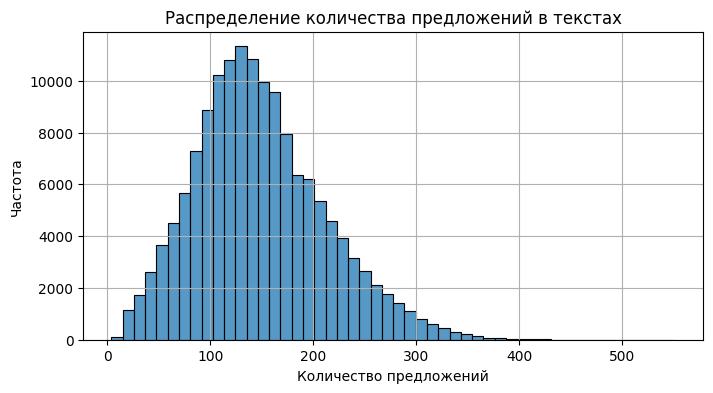

Статистические характеристики количества предложений:
count    147592.000000
mean        148.216861
std          63.216066
min           4.000000
25%         104.000000
50%         141.000000
75%         186.000000
max         551.000000
Name: Sentence_Count, dtype: float64


In [ ]:
def calculate_sentence_count(sentences):
    return len(sentences)

df_preprocessing['Sentence_Count'] = Parallel(n_jobs=-1)(
    delayed(calculate_sentence_count)(sentences) for sentences in tqdm(df_preprocessing['Sentences'], desc="Подсчет количества предложений")
)

plt.figure(figsize=(8, 4))
sns.histplot(df_preprocessing['Sentence_Count'], bins=50)
plt.title('Распределение количества предложений в текстах')
plt.xlabel('Количество предложений')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

print("Статистические характеристики количества предложений:")
print(df_preprocessing['Sentence_Count'].describe())

Фильтруем тексты по количеству предложений, удаляя записи с количеством предложений меньше **30** и больше **300**. После применения фильтрации выводим количество удаленных записей.

In [ ]:
min_sentence_count = 30
max_sentence_count = 300

initial_count = df_preprocessing.shape[0]
df_preprocessing = df_preprocessing[
    (df_preprocessing['Sentence_Count'] >= min_sentence_count) &
    (df_preprocessing['Sentence_Count'] <= max_sentence_count)
].reset_index(drop=True)
final_count = df_preprocessing.shape[0]

print(f"Удалено записей по длине предложений: {initial_count - final_count}")

Удалено записей по длине предложений: 4413


Повторно строим визуализацию количества предложений в текстах после очистки. Это позволяет оценить, как изменилось распределение количества предложений после фильтрации аномальных записей.

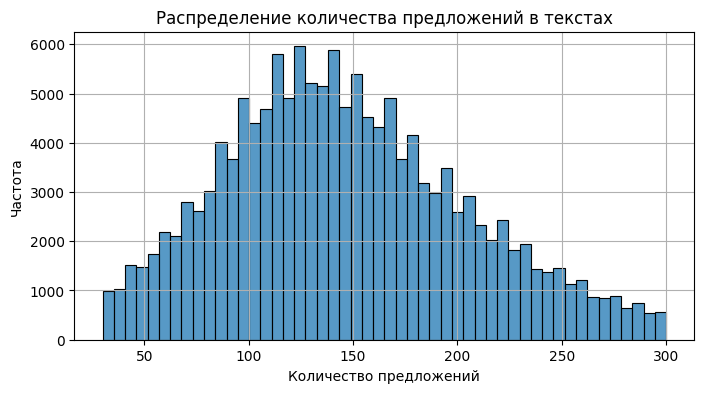

Статистические характеристики количества предложений:
count    143179.000000
mean        146.472800
std          57.542846
min          30.000000
25%         105.000000
50%         141.000000
75%         184.000000
max         300.000000
Name: Sentence_Count, dtype: float64


In [ ]:
plt.figure(figsize=(8, 4))
sns.histplot(df_preprocessing['Sentence_Count'], bins=50)
plt.title('Распределение количества предложений в текстах')
plt.xlabel('Количество предложений')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

print("Статистические характеристики количества предложений:")
print(df_preprocessing['Sentence_Count'].describe())

Удалив **4413** записей, мы получили более нормальное распределение количества предложений в текстах.

С помощью функции **`calculate_avg_sentence_length`** создаем новый столбец со средним количеством предложений в текстах и строим его визуализацию. Выводим описательную статистику по созданному столбцу.

Подсчет средней длины предложений:   0%|          | 0/143179 [00:00<?, ?it/s]

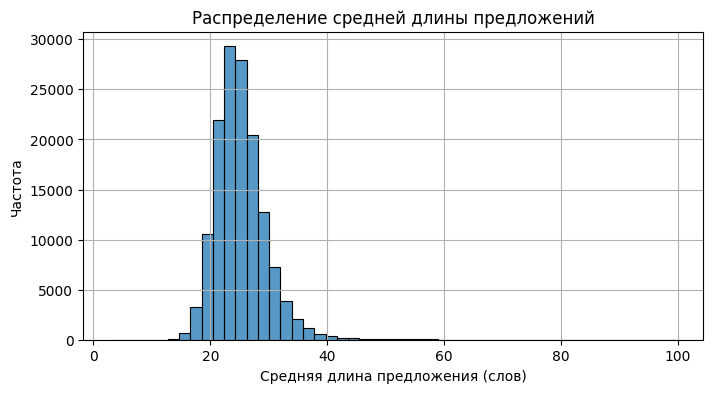

Статистические характеристики средней длины предложений:
count    143179.000000
mean         25.164753
std           4.373999
min           3.065891
25%          22.284091
50%          24.638554
75%          27.391899
max          99.483871
Name: Avg_Sentence_Length, dtype: float64


In [ ]:
def calculate_avg_sentence_length(sentences):
    sentence_lengths = [len(sentence.split()) for sentence in sentences]
    return sum(sentence_lengths) / len(sentence_lengths) if sentence_lengths else 0

df_preprocessing['Avg_Sentence_Length'] = Parallel(n_jobs=-1)(
    delayed(calculate_avg_sentence_length)(sentences) for sentences in tqdm(df_preprocessing['Sentences'], desc="Подсчет средней длины предложений")
)

plt.figure(figsize=(8, 4))
sns.histplot(df_preprocessing['Avg_Sentence_Length'], bins=50)
plt.title('Распределение средней длины предложений')
plt.xlabel('Средняя длина предложения (слов)')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

print("Статистические характеристики средней длины предложений:")
print(df_preprocessing['Avg_Sentence_Length'].describe())

Фильтруем тексты по средней длине предложений, удаляя записи с длиной предложений меньше **15** и больше **40** слов. После фильтрации выводим количество удаленных записей.

In [ ]:
min_sentence_length = 15
max_sentence_length = 40

initial_count = df_preprocessing.shape[0]
df_preprocessing = df_preprocessing[
    (df_preprocessing['Avg_Sentence_Length'] >= min_sentence_length) &
    (df_preprocessing['Avg_Sentence_Length'] <= max_sentence_length)
].reset_index(drop=True)
final_count = df_preprocessing.shape[0]

print(f"Удалено записей по длине предложений: {initial_count - final_count}")

Удалено записей по длине предложений: 1243


Повторно строим визуализацию средней длины предложений в текстах после очистки, чтобы оценить изменения в распределении после фильтрации аномальных значений.

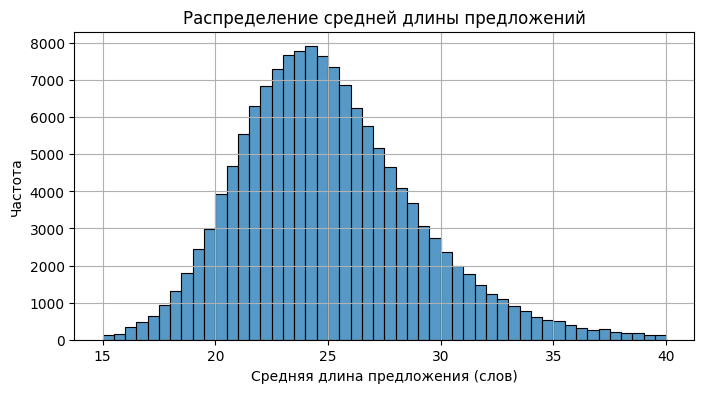

Статистические характеристики средней длины предложений:
count    141936.000000
mean         25.024840
std           3.949747
min          15.000000
25%          22.275229
50%          24.611111
75%          27.317684
max          40.000000
Name: Avg_Sentence_Length, dtype: float64


In [ ]:
plt.figure(figsize=(8, 4))
sns.histplot(df_preprocessing['Avg_Sentence_Length'], bins=50)
plt.title('Распределение средней длины предложений')
plt.xlabel('Средняя длина предложения (слов)')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

print("Статистические характеристики средней длины предложений:")
print(df_preprocessing['Avg_Sentence_Length'].describe())

Удалив **1243** записей, мы получили более нормальное распределение средней длины предложений в текстах.

### ***3.2.3 Уникальные слова***

С помощью функции **`compute_unique_word_percentage`** рассчитываем процент уникальных слов для каждого текста и добавляем результаты в новый столбец.

In [ ]:
def compute_unique_word_percentage(text):
    words = nltk.word_tokenize(text)
    num_words = len(words)
    unique_words = len(set(words))
    return (unique_words / num_words) * 100 if num_words > 0 else 0

unique_word_percentages = Parallel(n_jobs=-1)(delayed(compute_unique_word_percentage)(text) for text in tqdm(df_preprocessing['Clean_Text'], desc="Расчет процента уникальных слов"))

df_preprocessing['UniqueWordPercentage'] = unique_word_percentages

Расчет процента уникальных слов:   0%|          | 0/141936 [00:00<?, ?it/s]

Строим распределение процента уникальных слов и выводим описательную статистику по столбцу.

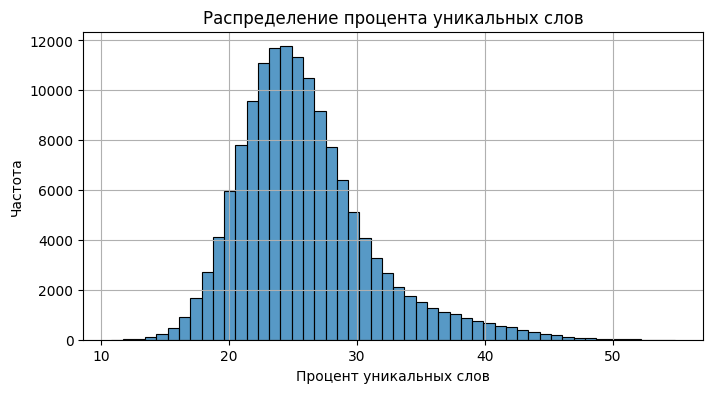

Статистические характеристики процента уникальных слов:
count    141936.000000
mean         25.893941
std           5.202576
min          10.806916
25%          22.414731
50%          25.108925
75%          28.362285
max          54.828660
Name: UniqueWordPercentage, dtype: float64


In [ ]:
plt.figure(figsize=(8,4))
sns.histplot(df_preprocessing['UniqueWordPercentage'], bins=50)
plt.title('Распределение процента уникальных слов')
plt.xlabel('Процент уникальных слов')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

print("Статистические характеристики процента уникальных слов:")
print(df_preprocessing['UniqueWordPercentage'].describe())

Удаляем записи, у которых процент уникальных слов не находится в пределах от **15%** до **45%**.

In [ ]:
condition = (df_preprocessing['UniqueWordPercentage'] >= 15) & (df_preprocessing['UniqueWordPercentage'] <= 45)

num_records_to_delete = df_preprocessing.shape[0] - df_preprocessing[condition].shape[0]

df_preprocessing = df_preprocessing[condition]

print(f'Количество записей, которые будут удалены: {num_records_to_delete}')

Количество записей, которые будут удалены: 893


Повторно строим распределение процента уникальных слов после очистки.

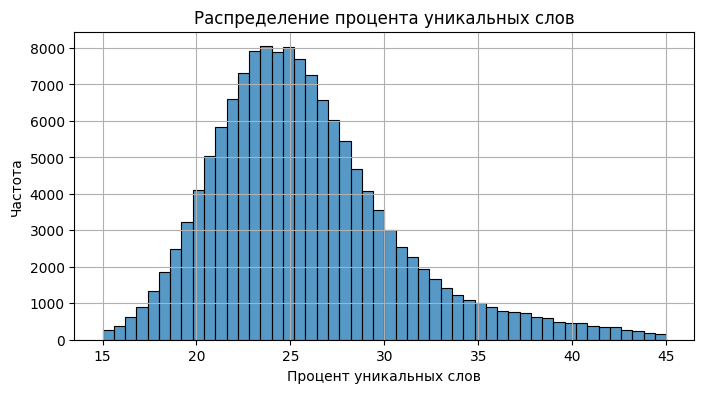

Статистические характеристики процента уникальных слов:
count    141043.000000
mean         25.838040
std           5.011089
min          15.003481
25%          22.424725
50%          25.100036
75%          28.319749
max          45.000000
Name: UniqueWordPercentage, dtype: float64


In [ ]:
plt.figure(figsize=(8,4))
sns.histplot(df_preprocessing['UniqueWordPercentage'], bins=50)
plt.title('Распределение процента уникальных слов')
plt.xlabel('Процент уникальных слов')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

print("Статистические характеристики процента уникальных слов:")
print(df_preprocessing['UniqueWordPercentage'].describe())

### ***3.2.4 Подсчет и фильтрация по количеству токенов***

Подсчитываем количество токенов в каждом тексте с помощью функции **`count_tokens_nltk`**, используя **NLTK** для токенизации. Результаты будут сохранены в новый столбец, а обработка будет выполнена параллельно для ускорения процесса.

In [ ]:
def count_tokens_nltk(text):
    tokens = word_tokenize(text)
    return len(tokens)

results = Parallel(n_jobs=-1)(
    delayed(count_tokens_nltk)(text) for text in tqdm(df_preprocessing['Clean_Text'], desc="Подсчет токенов", total=len(df_preprocessing))
)

df_preprocessing['token_count'] = results

Подсчет токенов:   0%|          | 0/141043 [00:00<?, ?it/s]

Строим гистограмму распределения количества токенов в текстах.

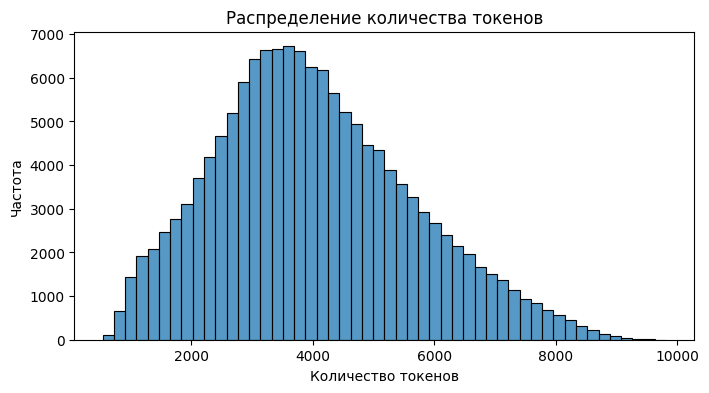

In [ ]:
df_preprocessing['token_count'] = results

plt.figure(figsize=(8, 4))
sns.histplot(df_preprocessing['token_count'], bins=50)
plt.title('Распределение количества токенов')
plt.xlabel('Количество токенов')
plt.ylabel('Частота')
plt.show()

Подсчитываем количество текстов с количеством токенов менее **1024**, более **8192**, а также между **1024** и **8192**, выводя соответствующие количества для каждой категории.

In [ ]:
print((df_preprocessing['token_count'] < 1024).sum())
print((df_preprocessing['token_count'] > 8192).sum())

print(((df_preprocessing['token_count'] >= 1024) & (df_preprocessing['token_count'] <= 8192)).sum())

1502
1158
138383


Оставляем только тексты с количеством токенов от **1024** до **8192**.

In [ ]:
df_preprocessing = df_preprocessing[(df_preprocessing['token_count'] >= 1024) & (df_preprocessing['token_count'] <= 8192)]

print(f"Оставшиеся записи: {len(df_preprocessing)}")

Оставшиеся записи: 138383


Строим гистограмму, чтобы визуализировать распределение количества токенов после фильтрации текстов, оставшихся в пределах от **1024** до **8192** токенов.

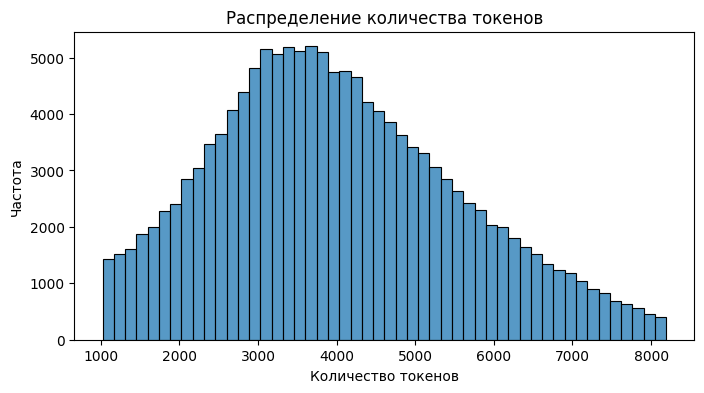

In [ ]:
plt.figure(figsize=(8, 4))
sns.histplot(df_preprocessing['token_count'], bins=50)
plt.title('Распределение количества токенов')
plt.xlabel('Количество токенов')
plt.ylabel('Частота')
plt.show()

Строим гистограмму распределения длины текстов в символах. Выводим описательную статистику по столбцу.

Статистические характеристки длины текстов:
count    138383.000000
mean      24396.475311
std        9499.718529
min        5731.000000
25%       17446.500000
50%       23410.000000
75%       30649.000000
max       55575.000000
Name: text_lenght, dtype: float64


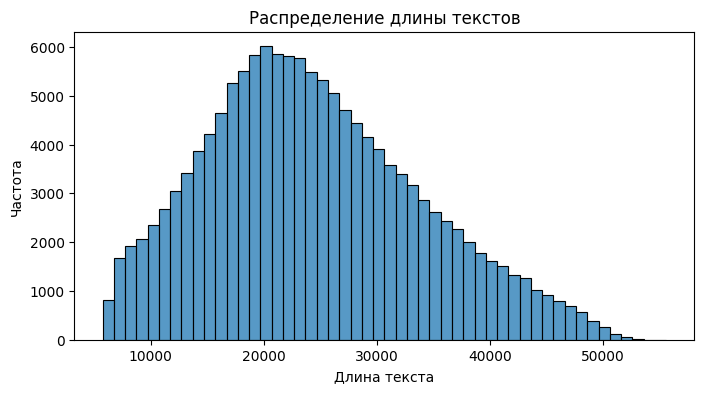

In [ ]:
df_preprocessing['text_lenght'] = df_preprocessing['Clean_Text'].apply(len)

plt.figure(figsize=(8,4))
sns.histplot(df_preprocessing['text_lenght'], bins=50)
plt.title('Распределение длины текстов')
plt.xlabel('Длина текста')
plt.ylabel('Частота')
plt

print('Статистические характеристки длины текстов:')
print(df_preprocessing['text_lenght'].describe())

Подсчитываем количество записей, не соответствующих критериям по длине текста **7500**–**50000** символов.

In [ ]:
condition = (df_preprocessing['text_lenght'] >= 7500) & (df_preprocessing['text_lenght'] <= 50000)

num_records_to_remove = df_preprocessing[~condition].shape[0]

print(f'Количество записей, которые не соответствуют критериям по длине текста: {num_records_to_remove}')

Количество записей, которые не соответствуют критериям по длине текста: 2419


Применена фильтрация для оставления только тех записей, длина текста которых находится в пределах от **7500** до **50000** символов.

In [ ]:
df_filtered = df_preprocessing[(df_preprocessing['text_lenght'] >= 7500) & (df_preprocessing['text_lenght'] <= 50000)]

Повторно строим гистограмму распределения длины текстов, чтобы визуализировать изменения после фильтрации.

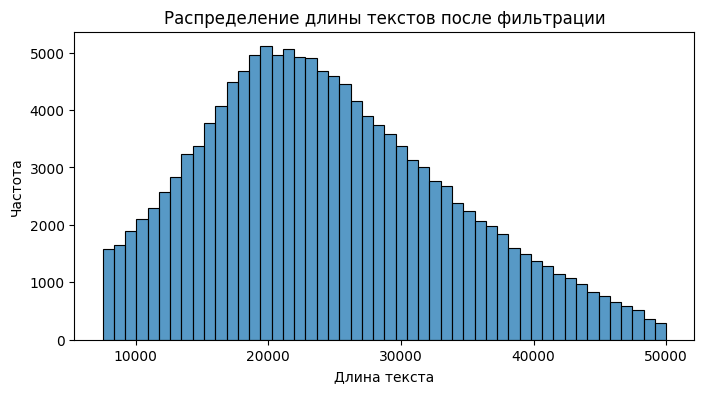

Статистические характеристки длины текстов:
count    135964.000000
mean      24607.823431
std        9241.586790
min        7500.000000
25%       17726.000000
50%       23564.000000
75%       30730.250000
max       50000.000000
Name: text_lenght, dtype: float64


In [ ]:
plt.figure(figsize=(8,4))
sns.histplot(df_filtered['text_lenght'], bins=50)
plt.title('Распределение длины текстов после фильтрации')
plt.xlabel('Длина текста')
plt.ylabel('Частота')
plt.show()

print('Статистические характеристки длины текстов:')
print(df_filtered['text_lenght'].describe())

In [ ]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 135964 entries, 0 to 141935
Data columns (total 15 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Title                 135964 non-null  object 
 1   Authors               135964 non-null  object 
 2   PMC Link              135964 non-null  object 
 3   Clean_Text            135964 non-null  object 
 4   Original_Length       135964 non-null  int64  
 5   Cleaned_Length        135964 non-null  int64  
 6   Reduction_Percentage  135964 non-null  float64
 7   Sentences             135964 non-null  object 
 8   Words                 135964 non-null  object 
 9   Word_Lengths          135964 non-null  object 
 10  Sentence_Count        135964 non-null  int64  
 11  Avg_Sentence_Length   135964 non-null  float64
 12  UniqueWordPercentage  135964 non-null  float64
 13  token_count           135964 non-null  int64  
 14  text_lenght           135964 non-null  int64  
dtypes: fl

### ***3.2.5 Общая визуализация и сохранения предобработанных данных***

Строим гистограммы для различных характеристик текста, таких как **длина текста**, **процент сокращения**, **длина слов**, **количество предложений** и другие. Для каждого столбца используется свой цвет, а на графиках отображаются линии плотности. Применяется **автоматическая подгонка** графиков, чтобы они не перекрывались.

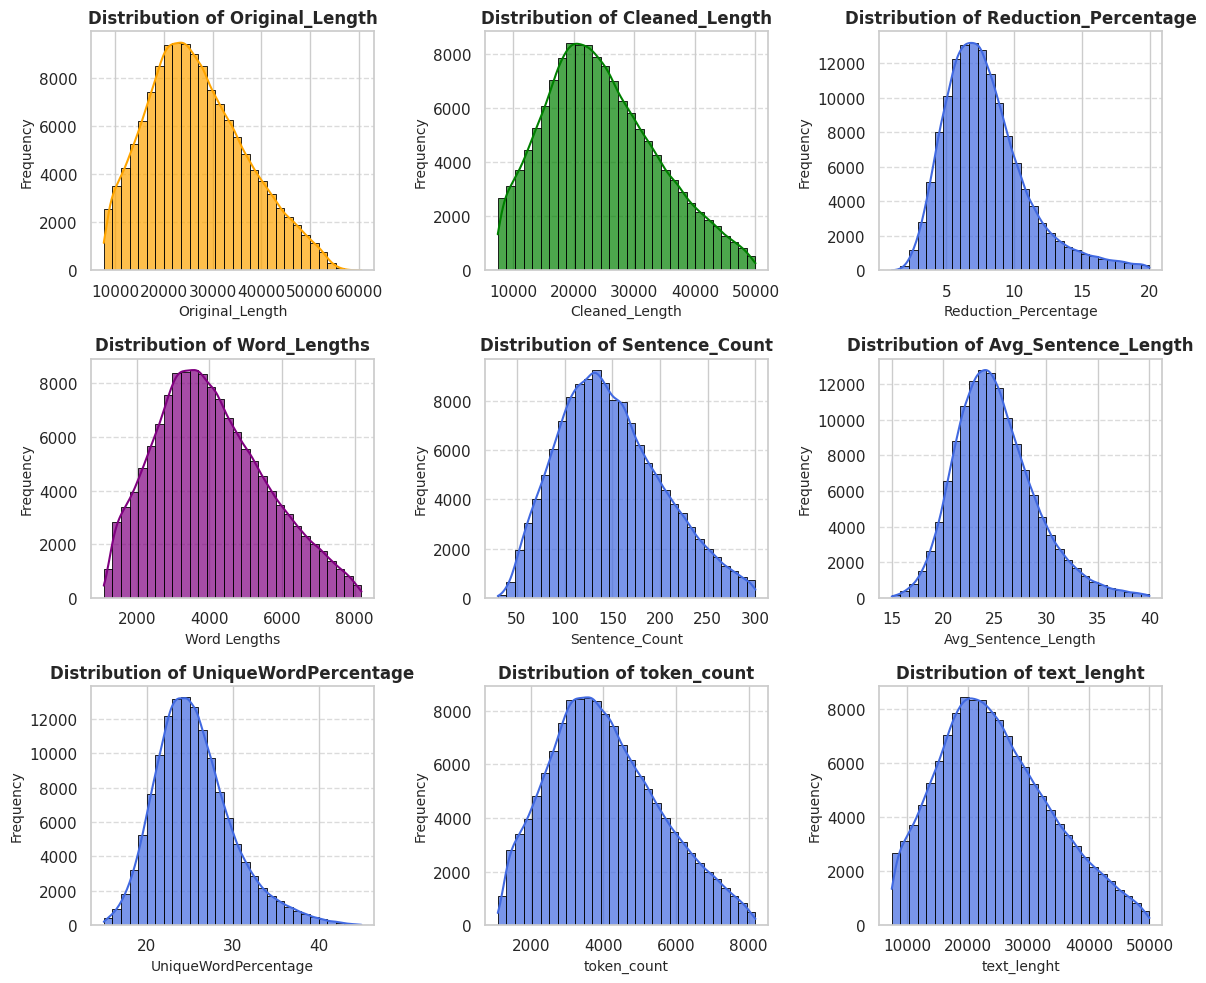

In [ ]:
sns.set(style='whitegrid')
plt.figure(figsize=(12, 10))

columns = [
    'Original_Length',
    'Cleaned_Length',
    'Reduction_Percentage',
    'Word_Lengths',
    'Sentence_Count',
    'Avg_Sentence_Length',
    'UniqueWordPercentage',
    'token_count',
    'text_lenght'
]

for i, column in enumerate(columns):
    plt.subplot(3, 3, i + 1)
    color = ('orange' if column == 'Original_Length' else
             'green' if column == 'Cleaned_Length' else
             'purple' if column == 'Word_Lengths' else
             'royalblue')
    data = df_filtered['Word_Lengths'].apply(len) if column == 'Word_Lengths' else df_filtered[column]

    sns.histplot(data, bins=30, kde=True, color=color, edgecolor='black', alpha=0.7)
    plt.title(f'Distribution of {column}', fontsize=12, fontweight='bold')
    plt.xlabel('Word Lengths' if column == 'Word_Lengths' else column, fontsize=10)
    plt.ylabel('Frequency', fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

Фильтруем данные, оставляя только необходимые столбцы: **Title**, **Authors**, **PMC Link**, и **Clean_Text**. Затем переименовываем столбец **Clean_Text** в **Text** и выводим информацию о структуре наборе данных.

In [ ]:
df_filtered = df_filtered.loc[:, ['Title', 'Authors', 'PMC Link', 'Clean_Text']].copy()

df_filtered.rename(columns={'Clean_Text': 'Text'}, inplace=True)

df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 135964 entries, 0 to 141935
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   Title     135964 non-null  object
 1   Authors   135964 non-null  object
 2   PMC Link  135964 non-null  object
 3   Text      135964 non-null  object
dtypes: object(4)
memory usage: 5.2+ MB


**Сохраняем обработанные данные, для дальнейших этапов**.

In [ ]:
df_filtered.to_csv(cleaned, index=False)

# ***4. Реализация и оценка качества суммаризаций***

### ***4.1 Суммаризация очищенных, сбалансированных текстов***

In [ ]:
df_clean = pd.read_csv(cleaned)

Функция **`tokenize_and_analyze`** обрабатывает текст, выполняя токенизацию и возвращая количество токенов и их список. Токенизация выполняется параллельно для всех текстов в колонке **`Text`**, а прогресс отображается.

Результаты сохраняются в двух новых колонках: **`Token_Count`** для количества токенов и **`Tokenized_Text`** для списка токенов. Вычисляются минимальное и максимальное значения количества токенов в наборе данных.

Для анализа создаются интервалы с шагом **256**, и из каждого выбирается до **5 случайных записей**. Итоговая выборка объединяется в единый **DataFrame** для дальнейшей работы.

In [ ]:
def tokenize_and_analyze(text):
    tokens = word_tokenize(text)
    return len(tokens), tokens

results = Parallel(n_jobs=-1)(
    delayed(tokenize_and_analyze)(text) for text in tqdm(df_clean['Text'], desc="Токенизация и анализ слов", total=len(df_clean))
)

df_clean['Token_Count'], df_clean['Tokenized_Text'] = zip(*results)

min_tokens = df_clean['Token_Count'].min()
max_tokens = df_clean['Token_Count'].max()

result_sample = []

for start in range(min_tokens, max_tokens + 256, 256):
    sampled = df_clean[(df_clean['Token_Count'] >= start) & (df_clean['Token_Count'] < start + 256)]
    result_sample.append(sampled.sample(n=min(5, len(sampled)), random_state=1))

result_sample = pd.concat(result_sample, ignore_index=True)

Токенизация и анализ слов:   0%|          | 0/135964 [00:00<?, ?it/s]

In [ ]:
print(f"Минимальное количество токенов: {result_sample['Token_Count'].min()}, Максимальное количество токенов: {result_sample['Token_Count'].max()}")

Минимальное количество токенов: 1251, Максимальное количество токенов: 8093


Строим гистограмму распределения количества токенов в нашей сбалансированной выборке.

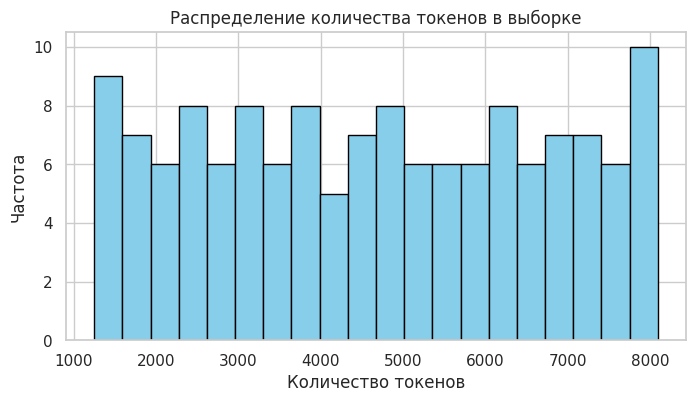

In [ ]:
plt.figure(figsize=(8, 4))
plt.hist(result_sample['Token_Count'], bins=20, color='skyblue', edgecolor='black')
plt.title('Распределение количества токенов в выборке')
plt.xlabel('Количество токенов')
plt.ylabel('Частота')
plt.show()

Загружаем токенизатор **SapBERT** и используем методы **LexRank**, **TextRank** и **LSA** для суммаризации текста. Функция **`summarize_text`** создает краткое содержание с учетом ограничений: минимальное и максимальное количество предложений (5–15) и лимит в **512 токенов**. Если текст превышает лимит, он обрезается до конца последнего полного предложения.

In [ ]:
model_name = 'cambridgeltl/SapBERT-from-PubMedBERT-fulltext'
tokenizer = AutoTokenizer.from_pretrained(model_name)

def summarize_text(method, text, tokenizer, max_tokens=512, min_sentences=5, max_sentences=15):
    parser = PlaintextParser.from_string(text, Tokenizer('english'))
    summarizers = {
        'LexRank': LexRankSummarizer(),
        'TextRank': TextRankSummarizer(),
        'LSA': LsaSummarizer(),
    }

    if method in summarizers:
        num_sentences = max(min_sentences, min(max_sentences, max_tokens // 30))
        summary_sentences = summarizers[method](parser.document, sentences_count=num_sentences)
        summary = ' '.join(str(sentence) for sentence in summary_sentences)

        tokens = tokenizer.tokenize(summary)
        if len(tokens) > max_tokens:
            tokens = tokens[:max_tokens]
            summary = tokenizer.convert_tokens_to_string(tokens)
            last_sentence_end = summary.rfind('.')
            if last_sentence_end != -1:
                summary = summary[:last_sentence_end + 1]

        return summary

methods = ['LexRank', 'TextRank', 'LSA']

for method in methods:
    result_sample[f'{method}_Summary'] = Parallel(n_jobs=-1)(
        delayed(summarize_text)(method, text, tokenizer, max_tokens=512, min_sentences=5, max_sentences=15)
        for text in tqdm(result_sample['Text'], desc=f"Summarizing with {method}", total=len(result_sample))
    )

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/198 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/462 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/226k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Summarizing with LexRank:   0%|          | 0/140 [00:00<?, ?it/s]

Summarizing with TextRank:   0%|          | 0/140 [00:00<?, ?it/s]

Summarizing with LSA:   0%|          | 0/140 [00:00<?, ?it/s]

Отображаем примеры суммаризации текста, выполненной различными методами: **LexRank**, **TextRank** и **LSA**.

In [ ]:
result_sample.head()

,Title,Authors,PMC Link,Text,Token_Count,Tokenized_Text,LexRank_Summary,TextRank_Summary,LSA_Summary
0,A Case Report of a 37-Year-Old Alzheimer's Dis...,"Yoo Hyun Um, Woo Hee Choi, Won Sang Jung, Youn...",https://pmc.ncbi.nlm.nih.gov/articles/PMC5561413/,Amyloid deposition has long been considered on...,1344,"[Amyloid, deposition, has, long, been, conside...","moreover, disruption in amyloid hypothesis has...","moreover, disruption in amyloid hypothesis has...","moreover, disruption in amyloid hypothesis has..."
1,Triple therapy: Three departments collaboratin...,"Francois Coetzee, Maria E. van Zyl, Maryke Gel...",https://pmc.ncbi.nlm.nih.gov/articles/PMC11304...,Undergraduate training of medic students shoul...,1326,"[Undergraduate, training, of, medic, students,...",undergraduate training of medic students shoul...,undergraduate training of medic students shoul...,undergraduate training of medic students shoul...
2,Two Unusual Aspects of Posterior Reversible En...,"Mazamaesso Tchaou, Nicoleta Modruz, Lama K. Ag...",https://pmc.ncbi.nlm.nih.gov/articles/PMC4637472/,"Described for the first time in by Hinchey, th...",1321,"[Described, for, the, first, time, in, by, Hin...",we report here two cases of posterior reversib...,"described for the first time in by hinchey, th...","Described for the first time in by Hinchey, th..."
3,Serrated adenocarcinoma of sigmoid colon with ...,"Diksha Karki, Sajan Ngakhusi",https://pmc.ncbi.nlm.nih.gov/articles/PMC10950...,"As per, the incidence of colorect cancer CRC, ...",1251,"[As, per, ,, the, incidence, of, colorect, can...","In, CRC was in third place in terms of inciden...","as per, the incidence of colorect cancer crc, ...",having a family history of colon cancer among ...
4,Secukinumab-Induced Lymphocytic Colitis,"Siva Santosh Kumar Gandu, Mohammad Hassaan Kha...",https://pmc.ncbi.nlm.nih.gov/articles/PMC9272475/,year-old white female was admitted with compla...,1309,"[year-old, white, female, was, admitted, with,...",she was started on secukinumab months prior to...,biopsies taken from the ascending and descendi...,year - old white female was admitted with comp...


Сохраняем полученные результаты в отдельный файл для последующего анализа.

In [ ]:
result_sample.to_csv('/content/drive/MyDrive/Colab Notebooks/pmc_articles/result_sample.csv', index=False)

### ***4.2 Оценка качества суммаризаций с использованием разных методов***

In [ ]:
result_sample = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/pmc_articles/result_sample.csv')

Вычисляем метрики для разных методов суммаризации: **LexRank**, **TextRank** и **LSA**. Для каждого метода рассчитываются:

- **Среднее отношение длины исходного текста к суммаризации**.
- **Минимальное**, **максимальное** и **среднее количество токенов** в суммаризациях.
- **Метрики BERTScore** (Precision, Recall, F1), **METEOR** и **ROUGE F1** для оценки качества суммаризаций.

Результаты сохраняются в словарь **`metrics`**, где для каждого метода хранится набор числовых метрик. После вычисления, метрики выводятся на экран.

In [ ]:
methods = ['LexRank', 'TextRank', 'LSA']

metrics = {}

for method in methods:
    texts = result_sample['Text'].tolist()
    summaries = result_sample[f'{method}_Summary'].tolist()

    text_token_counts = [len(word_tokenize(text)) for text in texts]
    summary_token_counts = [len(word_tokenize(summary)) for summary in summaries]
    average_ratio = mean(t / s for t, s in zip(text_token_counts, summary_token_counts) if s > 0)

    summary_length_min = min(summary_token_counts)
    summary_length_max = max(summary_token_counts)
    summary_length_mean = mean(summary_token_counts)

    bertscore_results = bertscore.compute(predictions=summaries, references=texts, lang='en')
    meteor_score = meteor.compute(predictions=summaries, references=texts)['meteor']
    rouge_f1 = rouge.compute(predictions=summaries, references=texts)

    bertscore_precision = mean(bertscore_results['precision'])
    bertscore_recall = mean(bertscore_results['recall'])
    bertscore_f1 = mean(bertscore_results['f1'])

    metrics[method] = {
        'Average_Ratio': average_ratio,
        'Summary_Length_Min': summary_length_min,
        'Summary_Length_Max': summary_length_max,
        'Summary_Length_Mean': summary_length_mean,
        'BERTScore_Precision': bertscore_precision,
        'BERTScore_Recall': bertscore_recall,
        'BERTScore_F1': bertscore_f1,
        'METEOR': meteor_score,
        'ROUGE_F1': rouge_f1,
    }

for method, metric in metrics.items():
    print(f"Метрики для {method}:")
    for k, v in metric.items():
        print(f"{k}: {v}")
    print("\n")

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Метрики для LexRank:
Average_Ratio: 10.953469314086453
Summary_Length_Min: 130
Summary_Length_Max: 491
Summary_Length_Mean: 438.3071428571429
BERTScore_Precision: 0.8327899128198624
BERTScore_Recall: 0.8344880163669586
BERTScore_F1: 0.8335992791822978
METEOR: 0.07901273283340357
ROUGE_F1: {'rouge1': 0.20988177820659704, 'rouge2': 0.20438536568454377, 'rougeL': 0.2090110140628414, 'rougeLsum': 0.20915579158549374}


Метрики для TextRank:
Average_Ratio: 11.124621070634772
Summary_Length_Min: 225
Summary_Length_Max: 498
Summary_Length_Mean: 433.4714285714286
BERTScore_Precision: 0.8324535250663757
BERTScore_Recall: 0.8388184483562197
BERTScore_F1: 0.8356002513851438
METEOR: 0.07824051614166626
ROUGE_F1: {'rouge1': 0.20970573848859086, 'rouge2': 0.20510337859648134, 'rougeL': 0.20855760796382086, 'rougeLsum': 0.20887710341212723}


Метрики для LSA:
Average_Ratio: 12.104194441418452
Summary_Length_Min: 274
Summary_Length_Max: 483
Summary_Length_Mean: 390.6642857142857
BERTScore_Precision: 0

Все три метода суммаризации показывают хорошие результаты, но **TextRank** и **LexRank** немного выигрывают по качеству.

- **TextRank** выделяется среди остальных благодаря лучшим показателям **Recall** и **F1** в **BERTScore** и схожим результатам по **ROUGE** с **LexRank**. Он немного более сбалансирован, с соотношением длины исходного текста и суммаризации **11.12** и средней длиной суммаризации около **433 токенов**.
- **LexRank** тоже хорош, особенно по меткам **BERTScore**, но немного уступает **TextRank** в **Recall** и **F1**. Его соотношение длины текста к суммаризации чуть ниже — **10.95**, а средняя длина суммаризации — **438 токенов**.
- **LSA** выглядит немного хуже из-за более низких показателей по **ROUGE**, несмотря на хорошие результаты по **BERTScore** (особенно **Precision**, **Recall** и **F1**). Его среднее соотношение — **12.10**, а средняя длина суммаризации — **391 токен**.

### ***4.3 Суммаризация с помощью TextRank***

In [ ]:
df_clean = pd.read_csv(cleaned)

Загружаем токенизатор модели **PubMedBERT-fulltext** для дальнейшей обработки текста.

In [ ]:
model_name = 'cambridgeltl/SapBERT-from-PubMedBERT-fulltext'
tokenizer = AutoTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


* С помощью функции **`extract_case_words`** извлекаем слова с особыми регистрами, такими как все заглавные буквы (**upper**) и стиль **CamelCase** (где слово начинается с маленькой буквы, а затем идет заглавная буква). Для каждого найденного слова в тексте сохраняем его в словарь **case_words**, где ключом является слово в нижнем регистре, а значением — тип регистра.

* Для суммаризации текста используем метод **TextRank**. В функции **`summarize_text`** рассчитываем количество предложений, которые будут входить в итоговую суммаризацию, с учетом максимального числа токенов (**max_tokens = 512**) и минимального и максимального числа предложений. Далее, если количество токенов в суммаризации превышает допустимый лимит (**512**), мы обрезаем суммаризацию до этого лимита и удостоверяемся, что конец обрезанного текста не нарушает целостности последнего предложения.

* После получения суммаризации восстанавливаем исходный регистр слов, используя словарь **case_words**. Для этого каждый токен из суммаризации проверяется: если слово присутствует в словаре, то восстанавливается его оригинальный регистр (например, заглавные буквы или стиль CamelCase).

* Также, чтобы каждое предложение начиналось с заглавной буквы, применяем дополнительные изменения, обеспечивая правильный формат для первого символа каждого предложения.

* После получения финальной версии суммаризации подсчитываем количество токенов в каждой суммаризации и сохраняем это значение в столбец **`Token_Count`**. Это позволяет отслеживать длину суммаризации в терминах токенов.

* Подсчитываем количество текстов, чьи суммаризации содержат больше **512 токенов**, и выводим это число для анализа.

In [ ]:
def extract_case_words(text):
    case_words = {}
    upper_case_words = re.findall(r'\b[A-Z]{2,}\b', text)
    for word in upper_case_words:
        case_words[word.lower()] = 'upper'
    camel_case_words = re.findall(r'\b[a-z]+[A-Z][a-z]*\b', text)
    for word in camel_case_words:
        case_words[word.lower()] = 'camelCase'
    return case_words

def summarize_text(method, text, tokenizer, max_tokens=512, min_sentences=5, max_sentences=15):
    case_words = extract_case_words(text)
    parser = PlaintextParser.from_string(text, Tokenizer('english'))
    summarizer = TextRankSummarizer()

    num_sentences = max(min_sentences, min(max_sentences, max_tokens // 30))
    summary_sentences = summarizer(parser.document, sentences_count=num_sentences)
    summary = ' '.join(str(sentence) for sentence in summary_sentences)

    tokens = tokenizer.tokenize(summary)
    if len(tokens) > max_tokens:
        tokens = tokens[:max_tokens]
        summary = tokenizer.convert_tokens_to_string(tokens)
        last_sentence_end = summary.rfind('.')
        if last_sentence_end != -1:
            summary = summary[:last_sentence_end + 1]

    def restore_case_in_summary(summary, case_words):
        summary_tokens = summary.split()
        restored_summary = []
        for token in summary_tokens:
            token_lower = token.lower()
            if token_lower in case_words:
                if case_words[token_lower] == 'upper':
                    restored_summary.append(token.upper())
                elif case_words[token_lower] == 'camelCase':
                    restored_summary.append(token[0].lower() + token[1:])
            else:
                restored_summary.append(token)
        return ' '.join(restored_summary)

    summary = restore_case_in_summary(summary, case_words)

    sentences = re.split(r'(?<=[.!?])\s+', summary)
    summary = ' '.join(sentence[0].upper() + sentence[1:] if sentence else sentence for sentence in sentences)

    return summary

df_clean['Summary'] = Parallel(n_jobs=-1)(
    delayed(summarize_text)('TextRank', text, tokenizer, max_tokens=512, min_sentences=5, max_sentences=15)
    for text in tqdm(df_clean['Text'], desc="Summarizing with TextRank", total=len(df_clean))
)

def count_tokens_in_summary(summary):
    tokens = tokenizer.tokenize(summary)
    return len(tokens)

df_clean['Token_Count'] = df_clean['Summary'].apply(count_tokens_in_summary)

count_over_512_tokens = (df_clean['Token_Count'] > 512).sum()

print(f"Количество записей с более чем 512 токенами: {count_over_512_tokens}")

Summarizing with TextRank: 100%|██████████| 135964/135964 [30:29<00:00, 74.31it/s]


Количество записей с более чем 512 токенами: 0


Для проверки корректности и точности выполнения суммаризаций **вручную** просматриваем примеры готовых результатов. Это позволяет удостовериться в том, насколько **алгоритм** успешно передает основные идеи из исходных текстов и правильно их **сжимает** в компактные и **читаемые** версии.

In [ ]:
df_clean['Summary'][10]

'Although the mechanisms behind the association of or inflammations and CVD are partially unknown, systemic inflammation and endotoxemia are among the most studied pietiainen, and they both induce multiple metabolic alterations khovidhunkit maatta jimenez widely used high - throughput nuclear magnetic resonance NMR platform provides a broad range of clinically and analytically validated metabolic biomarker concentrations. In the cross - section part of our study, we analyzed whether signs of current or past infectious inflammatory or diseases are associated with circulating metabolites, including concentrations, compositions, and subclass distributions of lipoprotein particles, as well as levels of fatty acids fas, amino acids, ketone bodies, metabolic substrates, and various other metabolic markers determined by NMR spectroscopy - based methods in cohorts. The or parameters registered included radiographically determined caries lesions, periapic infections, the number and quality of r

Строим гистограмму распределения количества токенов в тексте. Выводим описательную статистику.

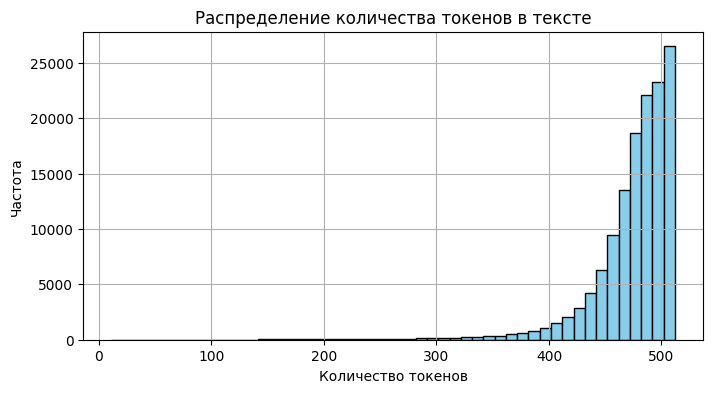

,Token_Count
count,135964.000000
mean,474.480657
std,38.129762
min,11.000000
25%,463.000000
50%,483.000000
75%,498.000000
max,512.000000


In [ ]:
plt.figure(figsize=(8, 4))
plt.hist(df_clean['Token_Count'], bins=50, color='skyblue', edgecolor='black')
plt.title('Распределение количества токенов в тексте')
plt.xlabel('Количество токенов')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

df_clean['Token_Count'].describe()

Фильтруем набор данных, выбирая записи, где количество токенов в тексте находится в диапазоне от **384** до **512**.

In [ ]:
summarized_df = df_clean[(df_clean['Token_Count'] >= 384) &(df_clean['Token_Count'] <= 512)]
summarized_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 132237 entries, 0 to 135963
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Title        132237 non-null  object
 1   Authors      132237 non-null  object
 2   PMC Link     132237 non-null  object
 3   Text         132237 non-null  object
 4   Summary      132237 non-null  object
 5   Token_Count  132237 non-null  int64 
dtypes: int64(1), object(5)
memory usage: 7.1+ MB


Повторно строим гистограмму распределения количества токенов в тексте. Выводим описательную статистику.

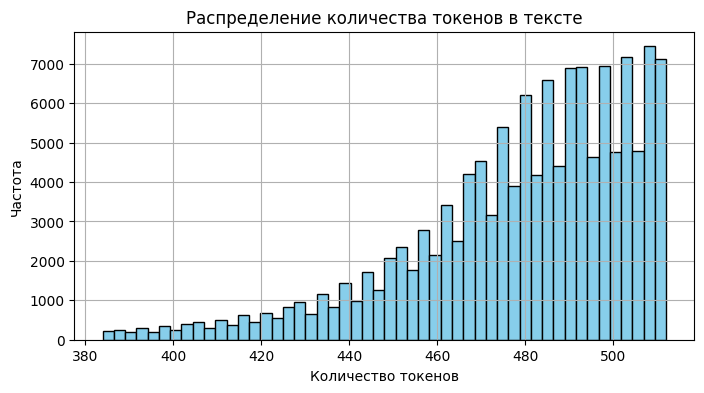

,Token_Count
count,132237.000000
mean,478.867896
std,25.734184
min,384.000000
25%,466.000000
50%,484.000000
75%,499.000000
max,512.000000


In [ ]:
plt.figure(figsize=(8, 4))
plt.hist(summarized_df['Token_Count'], bins=50, color='skyblue', edgecolor='black')
plt.title('Распределение количества токенов в тексте')
plt.xlabel('Количество токенов')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

summarized_df['Token_Count'].describe()

Удаляем столбцы **'Text'** и **'Token_Count'** из набора данных. Выводим структуру данных и сохраняем набор данных в CSV файл, исключая индексы.

In [ ]:
summarized_df = summarized_df.drop(columns=['Text', 'Token_Count'])

summarized_df.info()

summarized_df.to_csv(summarized, index=False)

<class 'pandas.core.frame.DataFrame'>
Index: 132237 entries, 0 to 135963
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   Title     132237 non-null  object
 1   Authors   132237 non-null  object
 2   PMC Link  132237 non-null  object
 3   Summary   132237 non-null  object
dtypes: object(4)
memory usage: 5.0+ MB


# ***5. Создание и классификация эмбендингов с модель >>>***

### ***5.1 Создание векторов***

In [ ]:
summarized_df = pd.read_csv(summarized)

Загружаем модель и токенизатор **SapBERT-from-PubMedBERT-fulltext** с использованием метода `from_pretrained`.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_name = 'cambridgeltl/SapBERT-from-PubMedBERT-fulltext'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name).to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/198 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/462 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/226k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

C помощью функции `embed_summaries_in_batches` извлекаем эмбеддинги для всех резюме в батчах. Для каждого батча выполняем токенизацию с заданными параметрами, подготавливаем входные данные для модели, а затем извлекаем эмбеддинги **CLS-токена**, которые добавляем в итоговый список. Эмбеддинги сохраняются как массивы **NumPy** и добавляются в столбец **Embeddings** набора данных **summarized_df**.

In [ ]:
def embed_summaries_in_batches(summaries, batch_size=96):
    embeddings = []

    for i in tqdm(range(0, len(summaries), batch_size), desc="Extracting embeddings"):
        batch = summaries[i:i + batch_size]
        inputs = tokenizer(batch, return_tensors="pt", truncation=True, padding=True, max_length=512, truncation_strategy='longest_first').to(device)

        with torch.no_grad():
            outputs = model(**inputs)
        batch_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
        embeddings.extend(batch_embeddings)

    return embeddings

summarized_df['Embeddings'] = embed_summaries_in_batches(summarized_df['Summary'].tolist(), batch_size=96)

Extracting embeddings:   0%|          | 0/1378 [00:00<?, ?it/s]

Просматриваем первые записи эмбеддингов в столбце **Embeddings** и проверяем их формат. Выводим тип данных первого элемента, чтобы убедиться, что это массив **NumPy**.

In [ ]:
summarized_df['Embeddings'].head()

print(type(summarized_df['Embeddings'][0]))

<class 'numpy.ndarray'>


Сохраняем набор данных в **CSV файл**, предварительно преобразуя эмбеддинги в строковый формат, чтобы они корректно записались в файл. Используем `np.array2string` для преобразования каждого эмбеддинга в строку с разделением элементов через запятую.

In [ ]:
summarized_df['Embeddings'] = summarized_df['Embeddings'].apply(lambda x: np.array2string(x, separator=','))
summarized_df.to_csv(embeddings, index=False)

### 5.2 Кластеризация векторов


Загружаем набор данных из **CSV** и преобразуем строковые представления эмбеддингов обратно в массивы **NumPy**. Убираем символы начала и конца строки с помощью среза и затем применяем `np.fromstring` для восстановления массивов.

In [ ]:
summarized_df = pd.read_csv(embeddings)

summarized_df['Embeddings'] = summarized_df['Embeddings'].apply(lambda x: np.fromstring(x[1:-1], sep=','))

Для проверки формата эмбеддингов выводим тип первого элемента из столбца **Embeddings**.

In [ ]:
# Проверка формата эмбеддингов
print(type(summarized_df['Embeddings'][0]))

<class 'numpy.ndarray'>


Выводим примеры столбца **Embeddings**.

In [ ]:
summarized_df['Embeddings'].head()

,Embeddings
0,"[0.0421965308, 0.0117269624, 0.457327992, 0.11..."
1,"[-0.150292099, -0.666049421, 0.364797711, 0.17..."
2,"[-0.0361765586, 0.340812325, 0.195551306, 0.48..."
3,"[-0.506924033, -0.598500192, -0.0142938467, 0...."
4,"[-0.865017772, -0.568018556, 0.93253237, 0.024..."


Загружаем **эмбеддинги** и применяем `t-SNE` для их проекции в **двумерное пространство**, что позволяет лучше визуализировать схожие группы данных. Метод помогает выделить структуры и зависимости в данных, упрощая их анализ. После этого **добавляем координаты** для дальнейшей работы с результатами.

In [ ]:
embeddings = np.array(summarized_df['Embeddings'].tolist())

num_embeddings = len(embeddings)
with tqdm(total=num_embeddings, desc="Processing embeddings") as pbar:

    for i in range(num_embeddings):
        pbar.update(1)

with tqdm(total=1, desc="Performing t-SNE") as pbar:
    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    embeddings_2d = tsne.fit_transform(embeddings)
    pbar.update(1)

summarized_df['x'] = embeddings_2d[:, 0]
summarized_df['y'] = embeddings_2d[:, 1]

Performing t-SNE: 100%|██████████| 1/1 [17:51<00:00, 1071.53s/it]


Вывод примеров **созданных** координат.

In [ ]:
summarized_df.head()

,Title,Authors,PMC Link,Summary,Embeddings,x,y
0,Androgen receptor profiling predicts prostate ...,"Suzan Stelloo, Ekaterina Nevedomskaya, Henk G ...",https://pmc.ncbi.nlm.nih.gov/articles/PMC4644377/,The target genes of the differenti binding reg...,"[0.0421965308, 0.0117269624, 0.457327992, 0.11...",39.095642,-81.220200
1,Arrested crossover precursor structures form s...,"Miao Tian, Kazufumi Mochizuki, Josef Loidl",https://pmc.ncbi.nlm.nih.gov/articles/PMC8849441/,"In the ciliatetetrahymena thermophila, dsbs no...","[-0.150292099, -0.666049421, 0.364797711, 0.17...",66.244110,-34.301468
2,Multiple interventions improve analgesic treat...,"Robert N Porter, Roger E Chafe, Leigh A Newhoo...",https://pmc.ncbi.nlm.nih.gov/articles/PMC4532201/,"Postintervention, the proportion of patients t...","[-0.0361765586, 0.340812325, 0.195551306, 0.48...",-88.891693,-20.983650
3,The use of virtual reality and augmented reali...,"Katherine Kuyt, Sang-Hee Park, Todd P. Chang, ...",https://pmc.ncbi.nlm.nih.gov/articles/PMC8040758/,Virtu reality VR and augmented reality AR have...,"[-0.506924033, -0.598500192, -0.0142938467, 0....",-89.901985,49.371964
4,MicroRNA-351 Regulates Two-Types of Cell Death...,"Akira Sato, Takuya Omi, Akihiro Yamamoto, Akit...",https://pmc.ncbi.nlm.nih.gov/articles/PMC4829180/,Necrosis in is characterized by the swelling o...,"[-0.865017772, -0.568018556, 0.93253237, 0.024...",61.830421,-62.260452


Строим график для визуализации двухмерных координат эмбеддингов статей. График отображает **семантические** связи между текстами на основе их **эмбеддингов**, где **каждая точка** соответствует статье, а **расположение точек** отражает их **схожесть** в смысле контекста.

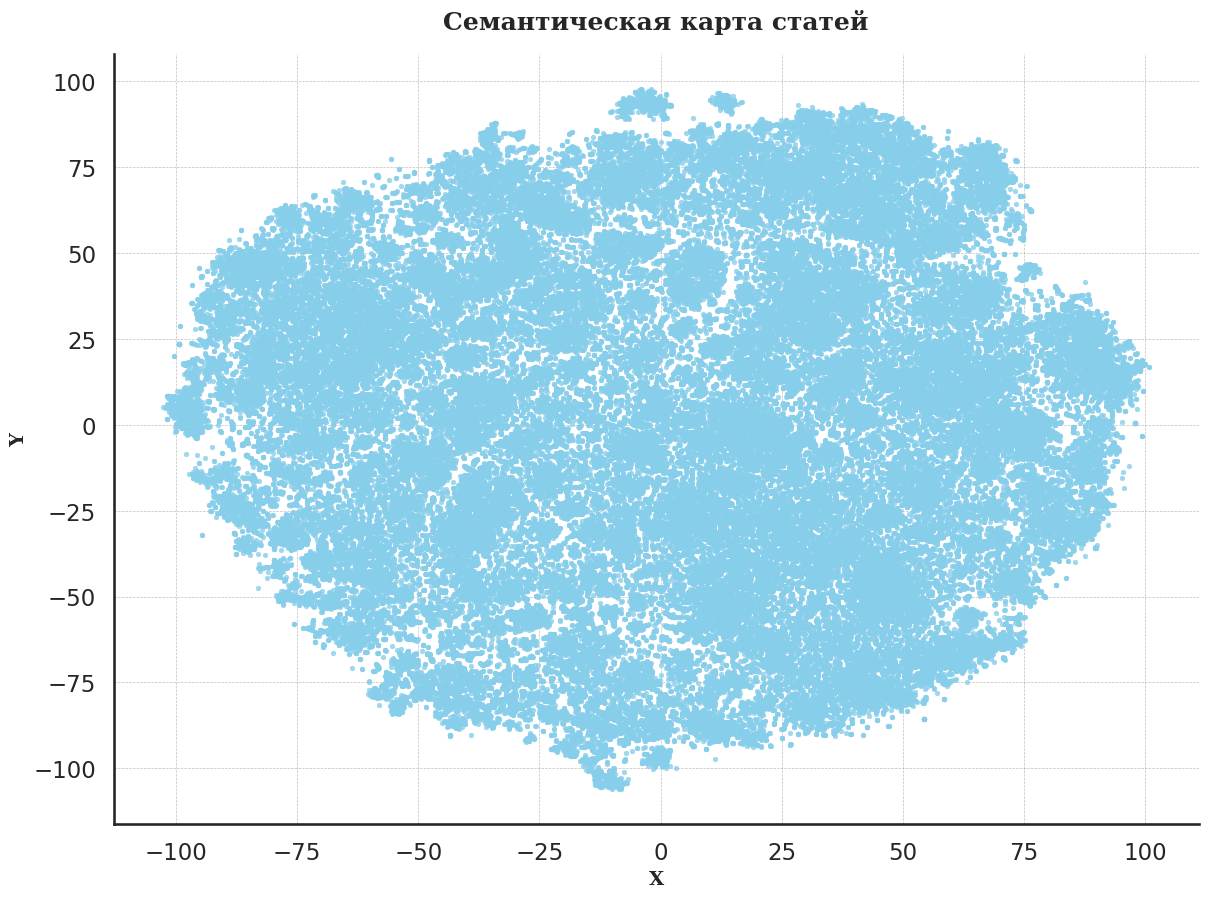

In [ ]:
plt.figure(figsize=(14, 10))
sns.set(style="white", palette="muted")
sns.set_context("talk")

scatter_plot = sns.scatterplot(
    x=summarized_df['x'], y=summarized_df['y'],
    color='skyblue',
    edgecolor=None,
    s=12, alpha=0.8,
    legend=False
)

plt.title("Семантическая карта статей", fontsize=18, pad=18, fontweight='bold', family='serif')
plt.xlabel("X", fontsize=14, fontweight='bold', family='serif')
plt.ylabel("Y", fontsize=14, fontweight='bold', family='serif')
plt.grid(visible=True, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
sns.despine()
plt.show()

Удаляем столбец с эмбеддингами из набора данных, чтобы сохранить только **текстовую информацию** и **координаты**. Затем сохраняем обновленный набор данных в **CSV** для дальнейшего использования.

In [ ]:
complete_df = summarized_df.drop(columns=['Embeddings'])
complete_df.to_csv(complete, index=False)

# ***6 Создание интерактивной визуализации***

### 1. **Инициализация Dash приложения**
   Приложение состоит из нескольких элементов:
   - **Поле ввода** для поиска, где пользователь может ввести название статьи или ссылку для поиска по точному совпадению, а также название статьи, автора или фрагмент краткого содержания для частичного поиска.
   - **Кнопки управления**:
     - **Поиск** — запускает поиск по введенному запросу.
     - **Main Map** — сбрасывает поиск и возвращает отображение всех статей.
   - **Зона для отображения информации** о выбранной статье и ее соседях, которая появляется при клике на статью.

### 2. **Поиск ближайших соседей**
   Для поиска ближайших соседей используется структура данных `KDTree`. С помощью этого алгоритма можно эффективно находить ближайшие статьи, основываясь на их координатах в многомерном пространстве.
   Это позволяет пользователю:
   - Выбрать статью на графике.
   - Узнать ее ближайших соседей и исследовать их, кликая по ним.

   Алгоритм поиска работает следующим образом:
   - При клике на статью ищутся ближайшие статьи в пространстве эмбеддингов.
   - Индексы ближайших соседей кэшируются, чтобы ускорить повторные запросы для того же элемента.

### 3. **Обновление информации о статье**
   Информация о выбранной статье обновляется динамически:
   - При выборе статьи пользователю показываются данные о ней, включая:
     - **Название**.
     - **Авторы**.
     - **Ссылка на полную статью (PMC Link)**.
     - **Краткое содержание**.
   - Также отображается список ближайших статей, если они есть.

### 4. **Обновление информации и карты**
   В зависимости от действий пользователя, приложение обновляет информацию о статьях и изменяет отображение карты:
   - **Клик по статье**:
     - При клике на статью показывается подробная информация о ней: название, авторы, ссылка на статью, краткое содержание.
     - Отображаются ближайшие статьи и их краткая информация.
   - **Поиск по точному совпадению**:
     - Когда пользователь вводит запрос в поле поиска и нажимает кнопку **Search**, приложение ищет статьи с точным совпадением по названию или ссылке.
     - Если точное совпадение найдено, показывается информация о статье, а также ее ближайшие соседи.
     - В случае, если точное совпадение не найдено, приложение выполняет поиск по **частичному совпадению**, используя ключевые слова из названия, авторов или краткого содержания статьи.
   - **Поиск по частичному совпадению**:
     - Когда точное совпадение не найдено, приложение ищет статьи, которые содержат введенный текст в любом из полей (название, авторы, краткое содержание).
     - Результаты отображаются на карте, и пользователь может изучать их взаимосвязи.
   - **Сброс поиска**:
     - При нажатии кнопки **Main Map** поиск сбрасывается, и отображаются все статьи без фильтрации.

### 5. **Структура данных и кэширование**
   Для улучшения производительности:
   - Соседние статьи для каждой выбранной статьи, а также результаты поиска кэшируются в **neighbors_cache** и **search_cache**, чтобы избежать повторных вычислений при одинаковых запросах.
   - Это позволяет ускорить процесс поиска ближайших соседей и обработки запросов, особенно при повторных кликах на одну и ту же статью.

### Заключение
Это приложение эффективно поддерживает поиск и отображение данных о статьях, позволяя пользователям искать статьи по точному и частичному совпадению, а также исследовать их взаимосвязи. Оно предоставляет удобный интерфейс для взаимодействия с научными статьями, их данными и соседними статьями на основе координат в пространстве эмбеддингов.

In [ ]:
complete_df = pd.read_csv(complete)

kdtree = KDTree(complete_df[['x', 'y']].values)
neighbors_cache = {}

app = dash.Dash(__name__)

app.layout = html.Div(
    style={'backgroundColor': 'black', 'color': 'white', 'font-family': 'Arial, sans-serif'},
    children=[
        html.Div(
            style={'padding': '20px', 'textAlign': 'center'},
            children=[
                html.H1("Interactive Map of Article Summaries", style={'margin-bottom': '20px', 'font-size': '2.5em', 'color': '#00BFFF'}),
                dcc.Input(
                    id='search-input',
                    type='text',
                    placeholder='Search...',
                    style={'width': '20%', 'padding': '5px', 'font-size': '12px', 'margin-right': '10px', 'border-radius': '5px', 'border': '1px solid #00BFFF'}
                ),
                html.Div(
                    style={'margin-top': '10px'},
                    children=[
                        html.Button("Search", id="search-button", style={'padding': '5px', 'backgroundColor': '#00BFFF', 'color': 'white', 'border': 'none', 'border-radius': '5px', 'margin-right': '10px'}),
                        html.Button("Main Map", id="main-map-button", style={'padding': '5px', 'backgroundColor': '#00BFFF', 'color': 'white', 'border': 'none', 'border-radius': '5px'})
                    ]
                )
            ]
        ),
        dcc.Loading(
            id="loading",
            type="circle",
            children=[dcc.Graph(id='scatter-plot', config={'displayModeBar': False})],
            style={'margin-top': '20px'}
        ),
        html.Div(id='info-container', style={
            'padding': '20px', 'backgroundColor': 'rgba(0, 0, 0, 0.8)', 'color': 'white',
            'border-radius': '10px', 'font-size': '16px', 'display': 'none', 'max-height': '300px', 'overflowY': 'auto'
        }),
        html.Div(id='neighbors-container', style={
            'padding': '10px', 'backgroundColor': 'rgba(0, 0, 0, 0.8)', 'color': 'white',
            'border-radius': '10px', 'font-size': '16px', 'display': 'none', 'margin-top': '20px'
        })
    ]
)

def create_figure(filtered_indices=None, selected_index=None, neighbors=[], zoom_range=None):
    fig = go.Figure()
    display_df = complete_df if filtered_indices is None else complete_df.loc[filtered_indices]

    fig.add_trace(go.Scattergl(
        x=display_df['x'], y=display_df['y'],
        mode='markers',
        marker=dict(size=10, color='skyblue', opacity=0.8, line=dict(width=1, color='white')),
        text=display_df['Title'],
        hoverinfo='text'
    ))

    if selected_index is not None:
        fig.add_trace(go.Scatter(
            x=[complete_df['x'].iloc[selected_index]], y=[complete_df['y'].iloc[selected_index]],
            mode='markers+text',
            marker=dict(size=14, color='yellow', symbol='diamond', line=dict(width=1, color='white')),
            text=[complete_df['Title'].iloc[selected_index]],
            hoverinfo='text'
        ))

        fig.add_trace(go.Scatter(
            x=complete_df.loc[neighbors, 'x'], y=complete_df.loc[neighbors, 'y'],
            mode='markers',
            marker=dict(size=12, color='magenta', symbol='circle', line=dict(width=1, color='white')),
            text=complete_df.loc[neighbors, 'Title'],
            hoverinfo='text'
        ))

        for neighbor in neighbors:
            fig.add_trace(go.Scatter(
                x=[complete_df['x'].iloc[selected_index], complete_df['x'].iloc[neighbor]],
                y=[complete_df['y'].iloc[selected_index], complete_df['y'].iloc[neighbor]],
                mode='lines',
                line=dict(color='white', width=1)
            ))

        all_x = [complete_df['x'].iloc[selected_index]] + [complete_df['x'].iloc[neighbor] for neighbor in neighbors]
        all_y = [complete_df['y'].iloc[selected_index]] + [complete_df['y'].iloc[neighbor] for neighbor in neighbors]
        zoom_range = {
            'x': [min(all_x) - 0.02, max(all_x) + 0.02],
            'y': [min(all_y) - 0.02, max(all_y) + 0.02]
        }

    if zoom_range:
        fig.update_xaxes(range=zoom_range['x'])
        fig.update_yaxes(range=zoom_range['y'])

    fig.update_layout(
        plot_bgcolor="black",
        paper_bgcolor="black",
        font_color="white",
        margin=dict(l=0, r=0, t=40, b=0),
        showlegend=False,
        title_x=0.5,
        title_font=dict(size=24)
    )
    fig.update_xaxes(visible=False)
    fig.update_yaxes(visible=False)

    return fig

def find_nearest_neighbors_cached(selected_index, num_neighbors=10):
    if selected_index in neighbors_cache:
        return neighbors_cache[selected_index]

    distances, indices = kdtree.query(complete_df[['x', 'y']].iloc[[selected_index]].values, k=num_neighbors + 1)
    neighbors_cache[selected_index] = indices[0][1:]
    return neighbors_cache[selected_index]

@app.callback(
    [Output('scatter-plot', 'figure'),
     Output('info-container', 'children'),
     Output('info-container', 'style'),
     Output('neighbors-container', 'children'),
     Output('neighbors-container', 'style'),
     Output('search-input', 'value')],
    [Input('scatter-plot', 'clickData'),
     Input('search-button', 'n_clicks'),
     Input('main-map-button', 'n_clicks')],
    [State('search-input', 'value'),
     State('scatter-plot', 'relayoutData')]
)
def update_map(clickData, search_button_clicks, main_map_clicks, search_value, relayout_data):
    selected_index = None
    neighbors = []
    info_style = {'display': 'none'}
    neighbors_style = {'display': 'none'}
    zoom_range = None
    info_content = ""
    neighbors_content = ""
    search_input_value = search_value

    ctx = dash.callback_context
    if not ctx.triggered:
        figure = create_figure()
        return figure, info_content, info_style, neighbors_content, neighbors_style, search_input_value

    trigger_id = ctx.triggered[0]['prop_id'].split('.')[0]

    if trigger_id == 'scatter-plot' and clickData is not None:
        x_clicked = clickData['points'][0]['x']
        y_clicked = clickData['points'][0]['y']

        distances, indices = kdtree.query([[x_clicked, y_clicked]], k=1)
        selected_index = indices[0][0]

        neighbors = find_nearest_neighbors_cached(selected_index)

        info_content = html.Div([
            html.H4(f"Title: {complete_df['Title'].iloc[selected_index]}"),
            html.P(f"Authors: {complete_df['Authors'].iloc[selected_index]}"),
            html.A("PMC Link", href=complete_df['PMC Link'].iloc[selected_index], target="_blank", style={'color': '#00BFFF'}),
            html.P(f"Summary: {complete_df['Summary'].iloc[selected_index]}")
        ])
        info_style = {'display': 'block'}

        neighbors_content = [
            html.Div([
                html.H4(f"Title: {complete_df['Title'].iloc[neighbor]}"),
                html.P(f"Authors: {complete_df['Authors'].iloc[neighbor]}"),
                html.A("PMC Link", href=complete_df['PMC Link'].iloc[neighbor], target="_blank", style={'color': '#00BFFF'}),
                html.P(f"Summary: {complete_df['Summary'].iloc[neighbor]}")
            ]) for neighbor in neighbors
        ]
        neighbors_style = {'display': 'block'}

        figure = create_figure(selected_index=selected_index, neighbors=neighbors, zoom_range=zoom_range)

    elif trigger_id == 'main-map-button':
        search_input_value = ''
        figure = create_figure()
        return figure, info_content, info_style, neighbors_content, neighbors_style, search_input_value

    elif trigger_id == 'search-button' and search_value:
        exact_match = complete_df[
            (complete_df['Title'].str.strip().str.lower() == search_value.strip().lower()) |
            (complete_df['PMC Link'].str.strip().str.lower() == search_value.strip().lower())
        ]

        if not exact_match.empty:
            selected_index = exact_match.index[0]
            neighbors = find_nearest_neighbors_cached(selected_index)

            info_content = html.Div([
                html.H4(f"Title: {complete_df['Title'].iloc[selected_index]}"),
                html.P(f"Authors: {complete_df['Authors'].iloc[selected_index]}"),
                html.A("PMC Link", href=complete_df['PMC Link'].iloc[selected_index], target="_blank", style={'color': '#00BFFF'}),
                html.P(f"Summary: {complete_df['Summary'].iloc[selected_index]}")
            ])
            info_style = {'display': 'block'}

            neighbors_content = [
                html.Div([
                    html.H4(f"Title: {complete_df['Title'].iloc[neighbor]}"),
                    html.P(f"Authors: {complete_df['Authors'].iloc[neighbor]}"),
                    html.A("PMC Link", href=complete_df['PMC Link'].iloc[neighbor], target="_blank", style={'color': '#00BFFF'}),
                    html.P(f"Summary: {complete_df['Summary'].iloc[neighbor]}")
                ]) for neighbor in neighbors
            ]
            neighbors_style = {'display': 'block'}

            figure = create_figure(selected_index=selected_index, neighbors=neighbors)
        else:
            filtered_df = complete_df[
                complete_df['Title'].str.contains(search_value, case=False, na=False) |
                complete_df['Authors'].str.contains(search_value, case=False, na=False) |
                complete_df['Summary'].str.contains(search_value, case=False, na=False)
            ]

            if not filtered_df.empty:
                figure = create_figure(filtered_indices=filtered_df.index)
            else:
                figure = create_figure()

            info_content = "No exact match found, showing partial matches."
            info_style = {'display': 'block'}
            neighbors_content = []
            neighbors_style = {'display': 'none'}

    if selected_index is not None:
        figure = create_figure(selected_index=selected_index, neighbors=neighbors, zoom_range=zoom_range)

    return figure, info_content, info_style, neighbors_content, neighbors_style, search_input_value

if __name__ == '__main__':
    app.run_server(debug=True)